# ml_trading_classifier.ipynb

Proyecto Final - Data Mining  
Modelo de clasificación para dirección diaria de precios (`target_up`) usando
la tabla `analytics.daily_features`.

## Objetivos

1. Definir la variable objetivo:  
   `target_up = 1 si close > open, en caso contrario 0`.
2. Construir un conjunto de features SIN LEAKAGE (solo usando información disponible
   hasta el inicio del día a predecir).
3. Hacer split temporal (Train / Validación / Test).
4. Entrenar y tunear **≥ 7 modelos de clasificación** de distintos tipos.
5. Comparar métricas (Accuracy, Precision, Recall, F1, ROC-AUC) y seleccionar el mejor modelo.
6. Evaluar el modelo ganador en Test.
7. Simular una estrategia de inversión simple con USD 10,000 en el último año (Test).
8. Exportar el modelo final como archivo `.pkl` (pipeline completo).


In [20]:
!pip install xgboost python-dotenv 


  Using cached xgboost-3.1.2-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.28.9-py3-none-manylinux_2_18_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-3.1.2-py3-none-manylinux_2_28_x86_64.whl (115.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 810.7 kB/s eta 0:00:000:0100:02m


In [9]:
# ml_trading_classifier.ipynb
# Proyecto Final - Data Mining - Modelo de Clasificación para Trading

import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv
import psycopg2

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay
)
from sklearn.dummy import DummyClassifier

# Modelos (≥7 modelos distintos)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier

import joblib

print("✅ Todas las librerías importadas correctamente")

✅ Todas las librerías importadas correctamente


In [10]:
# Configuración y variables de entorno
env_path = "/home/jovyan/work/.env"
if os.path.exists(env_path):
    load_dotenv(env_path)
    print(f" .env cargado desde: {env_path}")
else:
    print(" No se encontró .env, usando variables de entorno del sistema.")

PG_HOST = os.getenv("PG_HOST", "postgres")
PG_PORT = os.getenv("PG_PORT", "5432")
PG_DB   = os.getenv("PG_DB", "marketdb")
PG_USER = os.getenv("PG_USER", "postgres")
PG_PASSWORD = os.getenv("PG_PASSWORD", "postgres")

print("🔌 Conectando a Postgres con:")
print(f"  HOST: {PG_HOST}, PORT: {PG_PORT}, DB: {PG_DB}, USER: {PG_USER}")

def get_connection():
    """Establece conexión a PostgreSQL"""
    conn = psycopg2.connect(
        host=PG_HOST,
        port=PG_PORT,
        dbname=PG_DB,
        user=PG_USER,
        password=PG_PASSWORD
    )
    return conn

# Configuración principal
TICKER_MAIN = "AAPL"  # Puedes cambiar a MSFT, GOOG, etc.
print(f"🎯 Ticker seleccionado: {TICKER_MAIN}")

✅ .env cargado desde: /home/jovyan/work/.env
🔌 Conectando a Postgres con:
  HOST: postgres, PORT: 5432, DB: marketdb, USER: postgres
🎯 Ticker seleccionado: AAPL


In [11]:
print("📥 Cargando datos desde analytics.daily_features...")

conn = get_connection()

query = """
SELECT
    date,
    ticker,
    year,
    month,
    day_of_week,
    open,
    high,
    low,
    close,
    volume,
    return_close_open,
    return_prev_close,
    volatility_5d,
    run_id
FROM analytics.daily_features
WHERE ticker = %s
ORDER BY date;
"""

df_all = pd.read_sql(query, conn, params=[TICKER_MAIN])
conn.close()

print(f" Datos cargados: {len(df_all)} registros para {TICKER_MAIN}")
df_all.head()

📥 Cargando datos desde analytics.daily_features...
✅ Datos cargados: 1761 registros para AAPL


,date,ticker,year,month,day_of_week,open,high,low,close,volume,return_close_open,return_prev_close,volatility_5d,run_id
0,2018-01-02,AAPL,2018,1,1,42.540001,43.075001,42.314999,43.064999,102223600,0.012341,NaN,NaN,run_full_aapl_1
1,2018-01-03,AAPL,2018,1,2,43.132500,43.637501,42.990002,43.057499,118071600,-0.001739,-0.000174,NaN,run_full_aapl_1
2,2018-01-04,AAPL,2018,1,3,43.134998,43.367500,43.020000,43.257500,89738400,0.002840,0.004645,NaN,run_full_aapl_1
3,2018-01-05,AAPL,2018,1,4,43.360001,43.842499,43.262501,43.750000,94640000,0.008994,0.011385,NaN,run_full_aapl_1
4,2018-01-08,AAPL,2018,1,0,43.587502,43.902500,43.482498,43.587502,82271200,0.000000,-0.003714,NaN,run_full_aapl_1


🔄 Procesando datos y definiendo variable objetivo...
📊 Distribución de target_up:
target_up
Up            952
Down/Equal    809
Name: count, dtype: int64


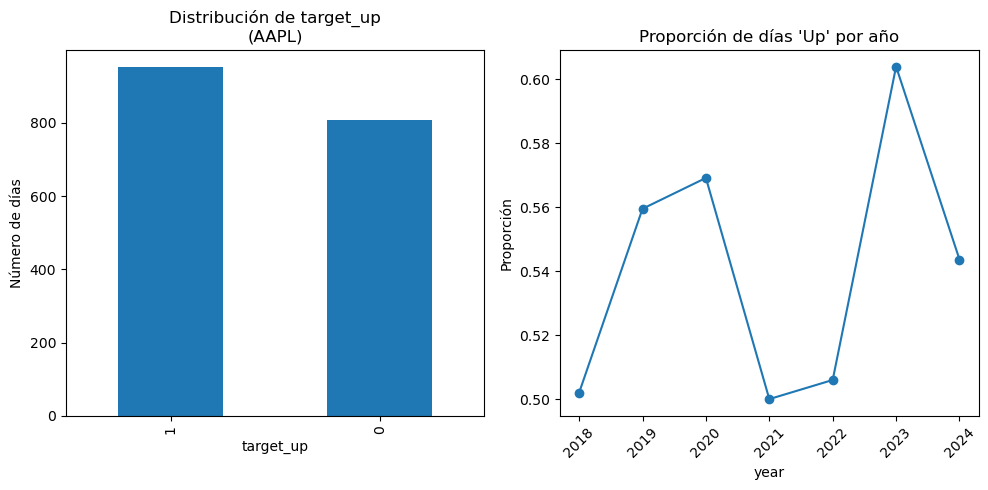

In [12]:

df = df_all.copy()
df["date"] = pd.to_datetime(df["date"])
df.sort_values("date", inplace=True)
df.reset_index(drop=True, inplace=True)

# Variable objetivo: target_up = 1 si close > open, 0 en caso contrario
df["target_up"] = (df["close"] > df["open"]).astype(int)

print(f"📊 Distribución de target_up:")
print(df["target_up"].value_counts().rename({0: "Down/Equal", 1: "Up"}))

# Gráfico de distribución
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df["target_up"].value_counts().plot(kind="bar")
plt.title(f"Distribución de target_up\n({TICKER_MAIN})")
plt.ylabel("Número de días")

plt.subplot(1, 2, 2)
df.groupby("year")["target_up"].mean().plot(kind="line", marker="o")
plt.title("Proporción de días 'Up' por año")
plt.ylabel("Proporción")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## EDA

📈 Generando EDA optimizado (Top 3 análisis más útiles para trading)...


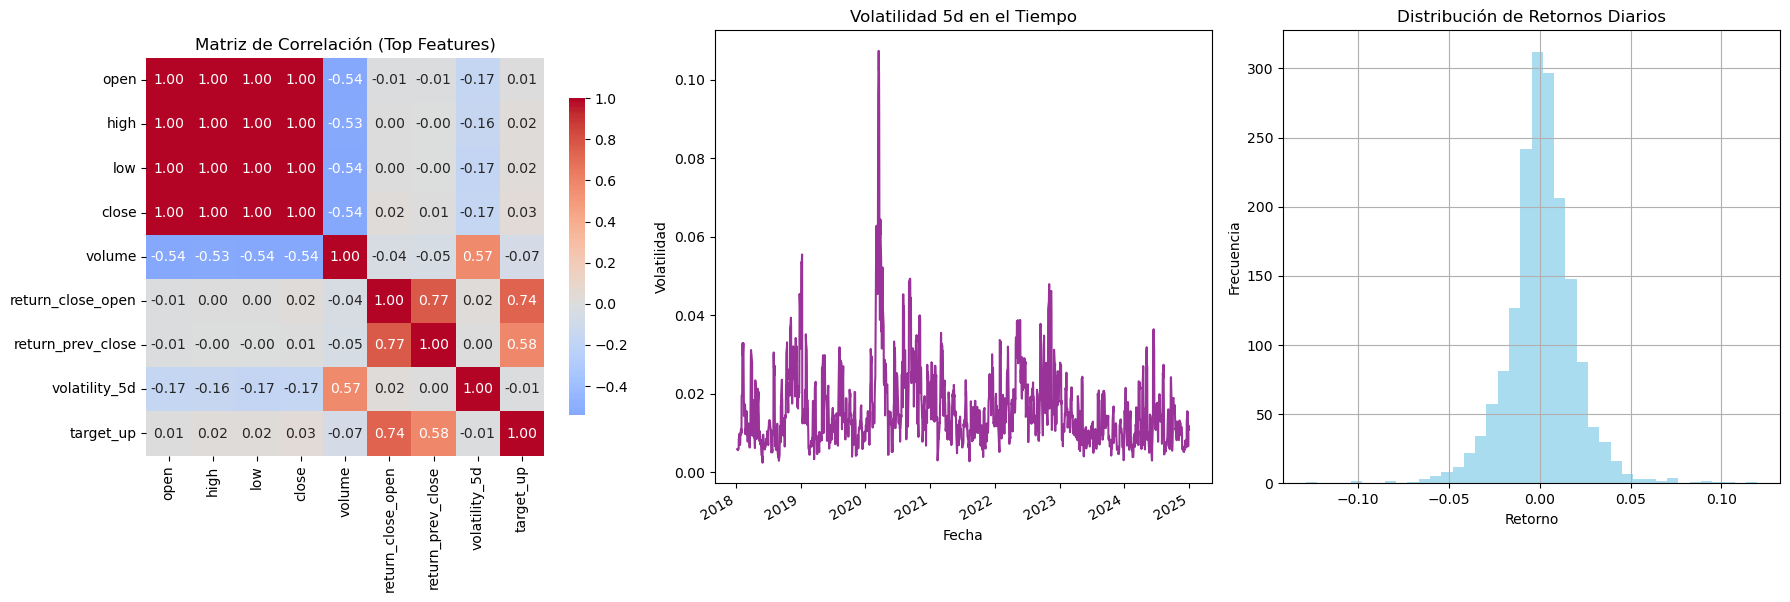


✔ EDA reducido generado correctamente.


In [13]:

df_eda = df.copy()

plt.figure(figsize=(18, 6))

# ==============================================
#  1. MATRIZ DE CORRELACIÓN
# ==============================================
plt.subplot(1, 3, 1)
numeric_cols = [
    'open', 'high', 'low', 'close', 'volume', 
    'return_close_open', 'return_prev_close', 
    'volatility_5d', 'target_up'
]
corr_matrix = df_eda[numeric_cols].corr()

sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    center=0, 
    square=True, 
    cbar_kws={"shrink": .7}
)
plt.title("Matriz de Correlación (Top Features)")

# ==============================================
# 🥈 2. VOLATILIDAD EN EL TIEMPO
# ==============================================
plt.subplot(1, 3, 2)
df_eda.set_index('date')['volatility_5d'].plot(
    color='purple', alpha=0.8, linewidth=1.5
)
plt.title("Volatilidad 5d en el Tiempo")
plt.ylabel("Volatilidad")
plt.xlabel("Fecha")

# ==============================================
# 🥉 3. DISTRIBUCIÓN DE RETORNOS DIARIOS
# ==============================================
plt.subplot(1, 3, 3)
df_eda['return_prev_close'].hist(
    bins=40, 
    alpha=0.7, 
    color='skyblue'
)
plt.title("Distribución de Retornos Diarios")
plt.xlabel("Retorno")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

print("\n✔ EDA reducido generado correctamente.")


## Ingeniería de features

In [14]:

df_feat = df.copy()
df_feat.sort_values("date", inplace=True)

# Groupby por ticker para calcular lags correctamente
g = df_feat.groupby("ticker")

# FEATURES SIN DATA LEAKAGE (solo información disponible al inicio del día)
# Lags de precios y retornos (información del día anterior)
df_feat["open_lag1"] = g["open"].shift(1)
df_feat["high_lag1"] = g["high"].shift(1)
df_feat["low_lag1"] = g["low"].shift(1)
df_feat["close_lag1"] = g["close"].shift(1)
df_feat["volume_lag1"] = g["volume"].shift(1)

# Lags de retornos y volatilidad
df_feat["return_close_open_lag1"] = g["return_close_open"].shift(1)
df_feat["return_prev_close_lag1"] = g["return_prev_close"].shift(1)
df_feat["volatility_5d_lag1"] = g["volatility_5d"].shift(1)

# Features adicionales (rolling sin leakage)
df_feat["volume_ma_5"] = g["volume"].shift(1).rolling(5).mean()
df_feat["range_hl_lag1"] = (g["high"].shift(1) - g["low"].shift(1)) / g["close"].shift(1)

# Primero limpiamos NaNs de estos lags básicos
initial_count = len(df_feat)
df_feat = df_feat.dropna(subset=[
    "open_lag1","high_lag1","low_lag1","close_lag1","volume_lag1",
    "return_close_open_lag1","return_prev_close_lag1","volatility_5d_lag1",
    "volume_ma_5","range_hl_lag1"
]).reset_index(drop=True)
after_basic_count = len(df_feat)

print(f" Features básicas creadas. Registros: {initial_count} → {after_basic_count} "
      f"(eliminados {initial_count - after_basic_count} por NaN en lags básicos)")

print(" Agregando features técnicas adicionales...")

# === Features técnicas adicionales (todas usando SOLO info pasada) ===
# Price range relativo
df_feat["price_range_pct"] = (df_feat["high_lag1"] - df_feat["low_lag1"]) / df_feat["close_lag1"]

# Cambio relativo de volumen
df_feat["volume_change"] = df_feat["volume_lag1"] / df_feat["volume_lag1"].shift(1)

# Relación de medias móviles 5 vs 20 (sobre close_lag1)
df_feat["ma_5"] = df_feat["close_lag1"].rolling(5).mean()
df_feat["ma_20"] = df_feat["close_lag1"].rolling(20).mean()
df_feat["ma_5_vs_20"] = df_feat["ma_5"] / df_feat["ma_20"]

# Momentum
df_feat["momentum_5"] = df_feat["close_lag1"] / df_feat["close_lag1"].shift(5) - 1
df_feat["momentum_10"] = df_feat["close_lag1"] / df_feat["close_lag1"].shift(10) - 1

# Volatilidad adicional
df_feat["volatility_10d"] = df_feat["return_prev_close_lag1"].rolling(10).std()
df_feat["volatility_20d"] = df_feat["return_prev_close_lag1"].rolling(20).std()

# RSI-like feature (simplificado)
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df_feat["rsi_14"] = calculate_rsi(df_feat["close_lag1"], 14)

# Ahora sí, dropna para TODAS las features nuevas
before_final = len(df_feat)
df_feat = df_feat.dropna().reset_index(drop=True)
final_count = len(df_feat)

print(f" Features técnicas añadidas. Registros: {after_basic_count} → {final_count} "
      f"(eliminados {after_basic_count - final_count} por NaN en técnicas)")

# Listar features creadas
feature_cols_debug = [col for col in df_feat.columns if 'lag1' in col or 'ma_' in col 
                      or 'range' in col or 'momentum' in col 
                      or 'volatility_' in col or 'rsi_' in col or 'price_range' in col 
                      or col in ["volume_ma_5"]]

print(f"\n📋 Total features de mercado creadas ({len(feature_cols_debug)}):")
for i, col in enumerate(feature_cols_debug, 1):
    print(f"  {i:2d}. {col}")

df_feat[['date', 'target_up'] + feature_cols_debug[:5]].head(10)


⚙️ Realizando ingeniería de features (sin data leakage)...
✅ Features básicas creadas. Registros: 1761 → 1755 (eliminados 6 por NaN en lags básicos)
🔄 Agregando features técnicas adicionales...
✅ Features técnicas añadidas. Registros: 1755 → 1736 (eliminados 19 por NaN en técnicas)

📋 Total features de mercado creadas (20):
   1. volatility_5d
   2. open_lag1
   3. high_lag1
   4. low_lag1
   5. close_lag1
   6. volume_lag1
   7. return_close_open_lag1
   8. return_prev_close_lag1
   9. volatility_5d_lag1
  10. volume_ma_5
  11. range_hl_lag1
  12. price_range_pct
  13. ma_5
  14. ma_20
  15. ma_5_vs_20
  16. momentum_5
  17. momentum_10
  18. volatility_10d
  19. volatility_20d
  20. rsi_14


,date,target_up,volatility_5d,open_lag1,high_lag1,low_lag1,close_lag1
0,2018-02-07,0,0.032767,38.707500,40.930000,38.500000,40.757500
1,2018-02-08,0,0.032896,40.772499,40.849998,39.767502,39.884998
2,2018-02-09,0,0.029736,40.072498,40.250000,38.757500,38.787498
3,2018-02-12,1,0.032824,39.267502,39.472500,37.560001,39.102501
4,2018-02-13,1,0.027323,39.625000,40.972500,39.377499,40.677502
5,2018-02-14,1,0.024489,40.487499,41.187500,40.412498,41.084999
6,2018-02-15,1,0.014292,40.759998,41.884998,40.720001,41.842499
7,2018-02-16,1,0.017589,42.447498,43.272499,42.250000,43.247501
8,2018-02-20,0,0.015613,43.090000,43.705002,42.942501,43.107498
9,2018-02-21,0,0.017144,43.012501,43.564999,42.855000,42.962502


## Definición de features y targets para el modelo

In [15]:

# Target
target_col = "target_up"

# Features numéricas (lags + técnicas, todas conocidas al inicio del día)
numeric_features = [
    "open_lag1",
    "high_lag1", 
    "low_lag1",
    "close_lag1",
    "volume_lag1",
    "return_close_open_lag1",
    "return_prev_close_lag1", 
    "volatility_5d_lag1",
    "volume_ma_5",
    "range_hl_lag1",
    # Técnicas adicionales
    "price_range_pct",
    "volume_change",
    "ma_5_vs_20",
    "momentum_5",
    "momentum_10",
    "volatility_10d",
    "volatility_20d",
    "rsi_14",
]

# Features categóricas (conocidas al inicio del día)
categorical_features = [
    "day_of_week",  # 0=lunes, 1=martes, ..., 4=viernes
    "month",        # 1=enero, ..., 12=diciembre
]

feature_cols = numeric_features + categorical_features

X = df_feat[feature_cols].copy()
y = df_feat[target_col].copy()

print(f" Dataset final:")
print(f"   • Features: {len(feature_cols)} ({len(numeric_features)} numéricas, {len(categorical_features)} categóricas)")
print(f"   • Registros: {len(X):,}")
print(f"   • Balance: {y.mean():.2%} días 'Up'")

print(f"\n📋 Lista completa de features:")
for i, col in enumerate(feature_cols, 1):
    feature_type = "num" if col in numeric_features else "cat"
    print(f"  {i:2d}. [{feature_type}] {col}")


🎯 Definiendo features y target para el modelo...
✅ Dataset final:
   • Features: 20 (18 numéricas, 2 categóricas)
   • Registros: 1,736
   • Balance: 54.21% días 'Up'

📋 Lista completa de features:
   1. [num] open_lag1
   2. [num] high_lag1
   3. [num] low_lag1
   4. [num] close_lag1
   5. [num] volume_lag1
   6. [num] return_close_open_lag1
   7. [num] return_prev_close_lag1
   8. [num] volatility_5d_lag1
   9. [num] volume_ma_5
  10. [num] range_hl_lag1
  11. [num] price_range_pct
  12. [num] volume_change
  13. [num] ma_5_vs_20
  14. [num] momentum_5
  15. [num] momentum_10
  16. [num] volatility_10d
  17. [num] volatility_20d
  18. [num] rsi_14
  19. [cat] day_of_week
  20. [cat] month


## División temporal de los datos

In [16]:


# Convertir año a entero
df_feat["year"] = df_feat["year"].astype(int)
years_available = sorted(df_feat["year"].unique())

# Definir splits temporales (ajustar según tus datos)
year_train_max = 2021
year_val_max = 2023
# Test = años > year_val_max (2024)

train_mask = df_feat["year"] <= year_train_max
val_mask   = (df_feat["year"] > year_train_max) & (df_feat["year"] <= year_val_max)
test_mask  = df_feat["year"] > year_val_max

print("📅 DIVISIÓN TEMPORAL:")
print(f"   • Años disponibles: {years_available}")
print(f"   • Train years: {sorted(df_feat.loc[train_mask, 'year'].unique())} "
      f"({train_mask.sum():,} registros)")
print(f"   • Val years  : {sorted(df_feat.loc[val_mask, 'year'].unique())} "
      f"({val_mask.sum():,} registros)")  
print(f"   • Test years : {sorted(df_feat.loc[test_mask, 'year'].unique())} "
      f"({test_mask.sum():,} registros)")

# Aplicar división
X_train = X[train_mask]
y_train = y[train_mask]

X_val = X[val_mask] 
y_val = y[val_mask]

X_test = X[test_mask]
y_test = y[test_mask]

print(f"\n📊 TAMAÑOS FINALES:")
print(f"   • Train: {X_train.shape} (y: {y_train.shape})")
print(f"   • Val  : {X_val.shape} (y: {y_val.shape})")
print(f"   • Test : {X_test.shape} (y: {y_test.shape})")

# Verificar que no hay overlap de fechas
train_dates = df_feat.loc[train_mask, "date"]
val_dates = df_feat.loc[val_mask, "date"] 
test_dates = df_feat.loc[test_mask, "date"]

print(f"\n✅ VERIFICACIÓN TEMPORAL:")
print(f"   • Train: {train_dates.min().strftime('%Y-%m-%d')} a {train_dates.max().strftime('%Y-%m-%d')}")
print(f"   • Val  : {val_dates.min().strftime('%Y-%m-%d')} a {val_dates.max().strftime('%Y-%m-%d')}")
print(f"   • Test : {test_dates.min().strftime('%Y-%m-%d')} a {test_dates.max().strftime('%Y-%m-%d')}")

⏰ Realizando división temporal de los datos...
📅 DIVISIÓN TEMPORAL:
   • Años disponibles: [2018, 2019, 2020, 2021, 2022, 2023, 2024]
   • Train years: [2018, 2019, 2020, 2021] (983 registros)
   • Val years  : [2022, 2023] (501 registros)
   • Test years : [2024] (252 registros)

📊 TAMAÑOS FINALES:
   • Train: (983, 20) (y: (983,))
   • Val  : (501, 20) (y: (501,))
   • Test : (252, 20) (y: (252,))

✅ VERIFICACIÓN TEMPORAL:
   • Train: 2018-02-07 a 2021-12-31
   • Val  : 2022-01-03 a 2023-12-29
   • Test : 2024-01-02 a 2024-12-31


## Preprocesamiento

In [17]:
print("🔧 Configurando pipeline de preprocesamiento...")

# Transformer para features numéricas
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# Transformer para features categóricas  
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Preprocessor combinado
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

print("✅ Pipeline de preprocesamiento configurado:")
print(f"   • Features numéricas: {len(numeric_features)}")
print(f"   • Features categóricas: {len(categorical_features)}")
print(f"   • Total features: {len(feature_cols)}")

# Probar el preprocesamiento
print("\n🧪 Probando preprocesamiento en sample...")
X_sample = X_train.head(5)
preprocessor.fit(X_sample)  # Solo para ver la transformación

if hasattr(preprocessor.named_transformers_['cat'], 'get_feature_names_out'):
    cat_features_encoded = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    print(f"   • Features categóricas después de encoding: {len(cat_features_encoded)}")
    
total_features_after_preprocessing = len(numeric_features) + len(cat_features_encoded)
print(f"   • Total features después de preprocesamiento: {total_features_after_preprocessing}")

🔧 Configurando pipeline de preprocesamiento...
✅ Pipeline de preprocesamiento configurado:
   • Features numéricas: 18
   • Features categóricas: 2
   • Total features: 20

🧪 Probando preprocesamiento en sample...
   • Features categóricas después de encoding: 6
   • Total features después de preprocesamiento: 24


## Entrenamiento del baseline

In [18]:
print("📊 Entrenando modelo baseline...")

# Baseline: siempre predecir la clase más frecuente
baseline = DummyClassifier(strategy="most_frequent")

baseline_pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", baseline)
])

# Entrenar baseline
baseline_pipe.fit(X_train, y_train)

# Predecir en validation
y_val_pred_baseline = baseline_pipe.predict(X_val)

# Métricas del baseline
acc_baseline = accuracy_score(y_val, y_val_pred_baseline)
f1_baseline = f1_score(y_val, y_val_pred_baseline)

print("📈 BASELINE MODEL (Most Frequent) - Validation:")
print(f"   • Accuracy : {acc_baseline:.4f}")
print(f"   • F1 Score : {f1_baseline:.4f}")
print(f"   • Predice siempre: '{'UP' if y_train.mode()[0] == 1 else 'DOWN/EQUAL'}'")

# Guardar métricas del baseline para comparación posterior
baseline_metrics = {
    'accuracy': acc_baseline,
    'f1': f1_baseline,
    'model': 'Baseline (Most Frequent)'
}

print(f"\n🎯 Objetivo: Los modelos ML deben superar F1 = {f1_baseline:.4f}")

📊 Entrenando modelo baseline...
📈 BASELINE MODEL (Most Frequent) - Validation:
   • Accuracy : 0.5549
   • F1 Score : 0.7137
   • Predice siempre: 'UP'

🎯 Objetivo: Los modelos ML deben superar F1 = 0.7137


## Configuración de los modelos

In [21]:
print("🤖 Configurando 7 modelos de ML con RandomizedSearchCV...")

from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Si no están instaladas las librerías, las instalamos
try:
    import xgboost as xgb
    import lightgbm as lgb
    print("✅ XGBoost y LightGBM disponibles")
except ImportError:
    print("⚠️  Instalando XGBoost y LightGBM...")
    !pip install xgboost lightgbm
    import xgboost as xgb
    import lightgbm as lgb
    print("✅ XGBoost y LightGBM instalados e importados")

models_and_params = []

# 1) Logistic Regression con distribuciones
log_reg = LogisticRegression(
    max_iter=3000,
    random_state=42,
    solver="saga",         # único solver compatible con l1 + l2 + elasticnet
    penalty="elasticnet",
    n_jobs=-1
)

params_log_reg = {
    "model__C": stats.loguniform(0.05, 5),     # rango óptimo para trading
    "model__l1_ratio": stats.uniform(0.0, 1.0),  # mezcla L1/L2 (0=L2 puro, 1=L1 puro)
    "model__class_weight": [None, "balanced"],
}
models_and_params.append(("LogisticRegression", log_reg, params_log_reg))

# 2) Linear SVC con distribuciones
svc = LinearSVC(max_iter=5000, random_state=42, dual='auto')
params_svc = {
    "model__C": stats.loguniform(0.01, 10),
    "model__loss": ["hinge", "squared_hinge"]
}
models_and_params.append(("LinearSVC", svc, params_svc))

# 3) Decision Tree con distribuciones
dt = DecisionTreeClassifier(random_state=42)
params_dt = {
    "model__max_depth": [3, 5, 7, 10, 15, 20, None],
    "model__min_samples_split": stats.randint(2, 20),
    "model__min_samples_leaf": stats.randint(1, 10),
    "model__criterion": ["gini", "entropy"],
    "model__max_features": ["sqrt", "log2", None]
}
models_and_params.append(("DecisionTree", dt, params_dt))

# 4) Random Forest con distribuciones
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params_rf = {
    "model__n_estimators": stats.randint(50, 500),
    "model__max_depth": [5, 10, 15, 20, None],
    "model__min_samples_split": stats.randint(2, 20),
    "model__min_samples_leaf": stats.randint(1, 10),
    "model__max_features": ["sqrt", "log2", 0.3, 0.5, 0.7],
    "model__bootstrap": [True, False]
}
models_and_params.append(("RandomForest", rf, params_rf))

# 5) XGBoost con distribuciones
xgb_clf = xgb.XGBClassifier(random_state=42, n_jobs=-1, verbosity=0)
params_xgb = {
    "model__n_estimators": stats.randint(50, 500),
    "model__learning_rate": stats.uniform(0.01, 0.3),  # 0.01 a 0.31
    "model__max_depth": stats.randint(3, 10),
    "model__subsample": stats.uniform(0.6, 0.4),  # 0.6 a 1.0
    "model__colsample_bytree": stats.uniform(0.6, 0.4),
    "model__reg_alpha": stats.loguniform(0.001, 10),
    "model__reg_lambda": stats.loguniform(0.001, 10),
    "model__gamma": stats.uniform(0, 5)
}
models_and_params.append(("XGBoost", xgb_clf, params_xgb))

# 6) LightGBM con distribuciones
lgb_clf = lgb.LGBMClassifier(random_state=42, n_jobs=-1, verbosity=-1,  boosting_type='gbdt')
params_lgb = {
    "model__n_estimators": stats.randint(50, 200),
    "model__learning_rate": stats.uniform(0.01, 0.1),
    "model__max_depth": stats.randint(3, 10),
    "model__num_leaves": stats.randint(20, 80),
    "model__subsample": stats.uniform(0.7, 0.2),                 # entre 0.7–0.9
    "model__colsample_bytree": stats.uniform(0.7, 0.2),
    "model__reg_alpha": stats.loguniform(0.0001, 1),             # sin exagerar regularización
    "model__reg_lambda": stats.loguniform(0.0001, 1)
}
models_and_params.append(("LightGBM", lgb_clf, params_lgb))

# 7) Gradient Boosting con distribuciones
gb = GradientBoostingClassifier(random_state=42)
params_gb = {
    "model__n_estimators": stats.randint(50, 300),
    "model__learning_rate": stats.uniform(0.01, 0.2),
    "model__max_depth": stats.randint(3, 8),
    "model__subsample": stats.uniform(0.6, 0.4),
    "model__min_samples_split": stats.randint(2, 20),
    "model__min_samples_leaf": stats.randint(1, 10)
}
models_and_params.append(("GradientBoosting", gb, params_gb))

print(f"✅ {len(models_and_params)} modelos configurados con RandomizedSearchCV")
print("🎯 CONFIGURACIÓN OPTIMIZADA:")
print("   • Se probarán 50 combinaciones ALEATORIAS por modelo")
print("   • Espacios de búsqueda MÁS AMPLIOS pero MÁS EFICIENTES")
print("   • Distribuciones continuas para parámetros numéricos")

print(f"\n📊 ESTIMACIÓN DE ITERACIONES:")
n_iter = 30  # Iteraciones por modelo
total_iterations = len(models_and_params) * n_iter * 5  # *3 por CV
print(f"   • Iteraciones por modelo: {n_iter}")
print(f"   • Total estimado: {total_iterations} ajustes de modelo")
print(f"   • Tiempo estimado: {total_iterations * 2 / 60:.1f} minutos")

print(f"\n🔍 DISTRIBUCIONES UTILIZADAS:")
print("   • stats.loguniform(): para parámetros de regularización")
print("   • stats.uniform(): para tasas de aprendizaje, ratios")
print("   • stats.randint(): para números enteros (árboles, profundidad)")
print("   • Listas fijas: para parámetros categóricos")

🤖 Configurando 7 modelos de ML con RandomizedSearchCV...
⚠️  Instalando XGBoost y LightGBM...
  Using cached lightgbm-4.6.0-py3-none-manylinux_2_28_x86_64.whl.metadata (17 kB)
Using cached lightgbm-4.6.0-py3-none-manylinux_2_28_x86_64.whl (3.6 MB)
✅ XGBoost y LightGBM instalados e importados
✅ 7 modelos configurados con RandomizedSearchCV
🎯 CONFIGURACIÓN OPTIMIZADA:
   • Se probarán 50 combinaciones ALEATORIAS por modelo
   • Espacios de búsqueda MÁS AMPLIOS pero MÁS EFICIENTES
   • Distribuciones continuas para parámetros numéricos

📊 ESTIMACIÓN DE ITERACIONES:
   • Iteraciones por modelo: 30
   • Total estimado: 1050 ajustes de modelo
   • Tiempo estimado: 35.0 minutos

🔍 DISTRIBUCIONES UTILIZADAS:
   • stats.loguniform(): para parámetros de regularización
   • stats.uniform(): para tasas de aprendizaje, ratios
   • stats.randint(): para números enteros (árboles, profundidad)
   • Listas fijas: para parámetros categóricos


## Verificación del Orden Temporal y No Solapamiento en los Conjuntos Train / Validation / Test

Este bloque comprueba que los datos estén correctamente ordenados por fecha y que no exista solapamiento temporal entre los subconjuntos de entrenamiento, validación y prueba. Esto es esencial en series temporales: garantiza que el modelo nunca vea datos futuros durante el entrenamiento y que la evaluación simule de forma realista un escenario de predicción en producción sin data leakage.

In [22]:
print("🔍 VERIFICANDO ORDEN TEMPORAL DE LOS DATOS...")

# Verificar que los datos estén ordenados por fecha
train_dates_sorted = df_feat[train_mask]["date"].is_monotonic_increasing
val_dates_sorted = df_feat[val_mask]["date"].is_monotonic_increasing
test_dates_sorted = df_feat[test_mask]["date"].is_monotonic_increasing

print("✅ VERIFICACIÓN DE ORDEN TEMPORAL:")
print(f"   • Train dates ordenadas: {train_dates_sorted}")
print(f"   • Validation dates ordenadas: {val_dates_sorted}")
print(f"   • Test dates ordenadas: {test_dates_sorted}")

# Verificar que no hay solapamiento temporal
train_max_date = df_feat[train_mask]["date"].max()
val_min_date = df_feat[val_mask]["date"].min()
val_max_date = df_feat[val_mask]["date"].max()
test_min_date = df_feat[test_mask]["date"].min()

print(f"\n📅 VERIFICACIÓN DE SOLAPAMIENTO:")
print(f"   • Train termina: {train_max_date.strftime('%Y-%m-%d')}")
print(f"   • Validation empieza: {val_min_date.strftime('%Y-%m-%d')}")
print(f"   • Validation termina: {val_max_date.strftime('%Y-%m-%d')}")
print(f"   • Test empieza: {test_min_date.strftime('%Y-%m-%d')}")

# Verificar que no hay solapamiento
no_overlap = (train_max_date < val_min_date) and (val_max_date < test_min_date)
print(f"   • ✅ Sin solapamiento temporal: {no_overlap}")

if not no_overlap:
    print("   🚨 CRÍTICO: Hay solapamiento temporal - Revisar split")
else:
    print("   ✅ Estructura temporal correcta")

🔍 VERIFICANDO ORDEN TEMPORAL DE LOS DATOS...
✅ VERIFICACIÓN DE ORDEN TEMPORAL:
   • Train dates ordenadas: True
   • Validation dates ordenadas: True
   • Test dates ordenadas: True

📅 VERIFICACIÓN DE SOLAPAMIENTO:
   • Train termina: 2021-12-31
   • Validation empieza: 2022-01-03
   • Validation termina: 2023-12-29
   • Test empieza: 2024-01-02
   • ✅ Sin solapamiento temporal: True
   ✅ Estructura temporal correcta


## Entrenamiento con  RandomizedSearchCV y TimeSeriesSplit

In [23]:

from sklearn.model_selection import TimeSeriesSplit

results = []
fitted_models = {}
n_iter = 20  # Número de combinaciones aleatorias a probar por modelo

# Configurar TimeSeriesSplit para respetar el orden temporal
tscv = TimeSeriesSplit(n_splits=5)  # 5 folds temporales

print("📅 CONFIGURACIÓN TIMESERIESSPLIT:")
print(f"   • Número de splits: {tscv.n_splits}")
print(f"   • Validación temporal: cada fold usa datos MÁS RECIENTES para validación")
print(f"   • Evita data leakage: no se usan datos FUTUROS para entrenar")

for name, model, param_distributions in models_and_params:
    print(f"\n{'='*70}")
    print(f"⏰ Entrenando: {name} (TimeSeriesSplit + RandomizedSearchCV)")
    print(f"{'='*70}")
    
    # Crear pipeline para el modelo
    pipe = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

    # Configurar RandomizedSearchCV con TimeSeriesSplit
    random_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring="f1",
        cv=tscv,                 
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    # IMPORTANTE: Asegurar que los datos de entrenamiento estén ordenados por fecha
    print(f"🔍 Buscando {n_iter} combinaciones con validación temporal...")
    
    # Entrenar modelo (X_train ya está ordenado por fecha desde Celda 8)
    random_search.fit(X_train, y_train)
    
    # Mejor modelo
    best_model = random_search.best_estimator_
    fitted_models[name] = best_model

    # Evaluar en validación (conjunto temporal separado)
    y_val_pred = best_model.predict(X_val)
    
    # Calcular métricas
    acc_val = accuracy_score(y_val, y_val_pred)
    f1_val = f1_score(y_val, y_val_pred)
    prec_val = precision_score(y_val, y_val_pred)
    rec_val = recall_score(y_val, y_val_pred)
    
    # ROC-AUC
    y_val_proba = None
    try:
        y_val_proba = best_model.predict_proba(X_val)[:, 1]
        roc_val = roc_auc_score(y_val, y_val_proba)
    except (AttributeError, IndexError):
        roc_val = np.nan

    print(f"✅ {name} completado con TimeSeriesSplit")
    print(f"   • Mejores parámetros: {random_search.best_params_}")
    print(f"   • Mejor score (CV temporal): {random_search.best_score_:.4f}")
    print(f"   • Validation - Acc: {acc_val:.4f}, F1: {f1_val:.4f}, ROC-AUC: {roc_val:.4f}")

    # Guardar resultados
    results.append({
        "model_name": name,
        "best_estimator": best_model,
        "best_params": random_search.best_params_,
        "best_cv_score": random_search.best_score_,
        "val_accuracy": acc_val,
        "val_f1": f1_val,
        "val_precision": prec_val,
        "val_recall": rec_val,
        "val_roc_auc": roc_val,
        "search_method": "RandomizedSearchCV_TimeSeriesSplit"
    })

print(f"\n🎉 Entrenamiento completado con VALIDACIÓN TEMPORAL.")
print(f"📊 {len(results)} modelos optimizados con TimeSeriesSplit")

🚀 Iniciando entrenamiento con RandomizedSearchCV y TimeSeriesSplit...
📅 CONFIGURACIÓN TIMESERIESSPLIT:
   • Número de splits: 5
   • Validación temporal: cada fold usa datos MÁS RECIENTES para validación
   • Evita data leakage: no se usan datos FUTUROS para entrenar

⏰ Entrenando: LogisticRegression (TimeSeriesSplit + RandomizedSearchCV)
🔍 Buscando 20 combinaciones con validación temporal...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ LogisticRegression completado con TimeSeriesSplit
   • Mejores parámetros: {'model__C': 0.053149590974688174, 'model__class_weight': None, 'model__l1_ratio': 0.9656320330745594}
   • Mejor score (CV temporal): 0.7007
   • Validation - Acc: 0.5349, F1: 0.6804, ROC-AUC: 0.4675

⏰ Entrenando: LinearSVC (TimeSeriesSplit + RandomizedSearchCV)
🔍 Buscando 20 combinaciones con validación temporal...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

✅ LinearSVC completado con TimeSeriesSplit
   • Mejores parámetros: {'model__C': 0.13292918943162169, 'model__loss': 'hinge'}
   • Mejor score (CV temporal): 0.5676
   • Validation - Acc: 0.5309, F1: 0.6252, ROC-AUC: nan

⏰ Entrenando: DecisionTree (TimeSeriesSplit + RandomizedSearchCV)
🔍 Buscando 20 combinaciones con validación temporal...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ DecisionTree completado con TimeSeriesSplit
   • Mejores parámetros: {'model__criterion': 'entropy', 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 9, 'model__min_samples_split': 18}
   • Mejor score (CV temporal): 0.5075
   • Validation - Acc: 0.5349, F1: 0.5528, ROC-AUC: 0.5437

⏰ Entrenando: RandomForest (TimeSeriesSplit + RandomizedSearchCV)
🔍 Buscando 20 combinaciones con validación temporal...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ RandomForest completado con TimeSeriesSplit
   • Mejores parámetros: {'model__bootstrap': T

## Evaluación de la Búsqueda de Hiperparámetros con RandomizedSearchCV

En este bloque se comparan todos los modelos entrenados con RandomizedSearchCV usando F1 en validación y se los contrasta contra un baseline que siempre predice la clase mayoritaria. La tabla y el gráfico permiten ver qué modelos se benefician más del tuning, cuánta variabilidad hay entre ellos y si realmente la búsqueda aleatoria de hiperparámetros logra encontrar configuraciones que mejoren (o no) al baseline.

📈 Analizando efectividad de RandomizedSearchCV...

🏆 COMPARACIÓN DE MODELOS (RandomizedSearchCV):


,model_name,best_cv_score,val_accuracy,val_f1,val_precision,val_recall,val_roc_auc
0,LogisticRegression,0.7007,0.5349,0.6804,0.5499,0.8921,0.4675
6,GradientBoosting,0.4724,0.5349,0.6260,0.5652,0.7014,0.4879
1,LinearSVC,0.5676,0.5309,0.6252,0.5616,0.7050,NaN
2,DecisionTree,0.5075,0.5349,0.5528,0.5926,0.5180,0.5437
3,RandomForest,0.5047,0.4770,0.5467,0.5267,0.5683,0.4554
4,XGBoost,0.6761,0.4830,0.5010,0.5394,0.4676,0.4791
5,LightGBM,0.4721,0.4770,0.4962,0.5331,0.4640,0.4714



💡 EFECTIVIDAD DE RANDOMIZEDSEARCHCV:
   • Total modelos: 7
   • Iteraciones por modelo: 20
   • Combinaciones totales probadas: 140
   • Mejor F1: 0.6804
   • Rango F1: 0.4962 - 0.6804

🎯 COMPARACIÓN CON BASELINE:
   • Baseline F1: 0.7137
   • Mejor modelo F1: 0.6804
   • Diferencia: -0.0334
   ⚠️  Ningún modelo supera el baseline - revisar features/data


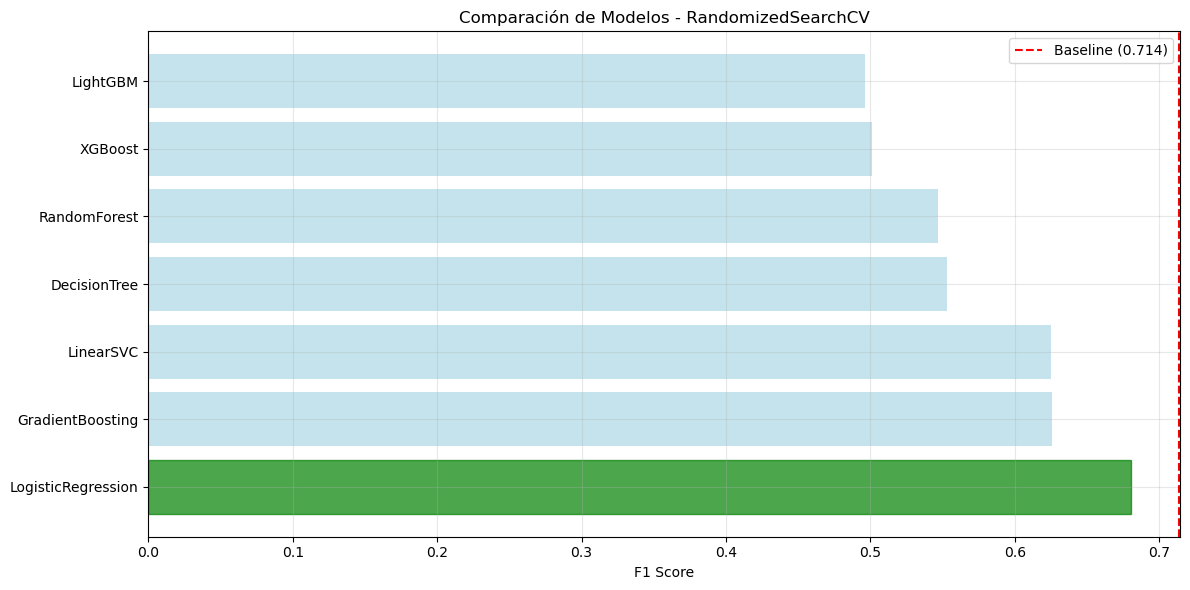

In [24]:
print("📈 Analizando efectividad de RandomizedSearchCV...")

# Crear DataFrame de resultados
results_df = pd.DataFrame(results)
results_df.sort_values("val_f1", ascending=False, inplace=True)

# Mostrar comparación
print("\n🏆 COMPARACIÓN DE MODELOS (RandomizedSearchCV):")
display_cols = ["model_name", "best_cv_score", "val_accuracy", "val_f1", "val_precision", "val_recall", "val_roc_auc"]
display(results_df[display_cols].round(4))

# Análisis de la estrategia
print(f"\n💡 EFECTIVIDAD DE RANDOMIZEDSEARCHCV:")
print(f"   • Total modelos: {len(results_df)}")
print(f"   • Iteraciones por modelo: {n_iter}")
print(f"   • Combinaciones totales probadas: {len(results_df) * n_iter}")
print(f"   • Mejor F1: {results_df['val_f1'].max():.4f}")
print(f"   • Rango F1: {results_df['val_f1'].min():.4f} - {results_df['val_f1'].max():.4f}")

# Comparar con baseline
baseline_f1 = baseline_metrics['f1']
best_model_f1 = results_df['val_f1'].max()

print(f"\n🎯 COMPARACIÓN CON BASELINE:")
print(f"   • Baseline F1: {baseline_f1:.4f}")
print(f"   • Mejor modelo F1: {best_model_f1:.4f}")
print(f"   • Diferencia: {best_model_f1 - baseline_f1:+.4f}")

if best_model_f1 > baseline_f1:
    print("   ✅ RandomizedSearchCV encontró modelo que supera baseline")
else:
    print("   ⚠️  Ningún modelo supera el baseline - revisar features/data")

# Gráfico de resultados
plt.figure(figsize=(12, 6))
models = results_df['model_name']
f1_scores = results_df['val_f1']

bars = plt.barh(range(len(models)), f1_scores, color='lightblue', alpha=0.7)
plt.axvline(x=baseline_f1, color='red', linestyle='--', label=f'Baseline ({baseline_f1:.3f})')

# Colorear el mejor modelo
best_idx = results_df['val_f1'].idxmax()
bars[best_idx].set_color('green')

plt.yticks(range(len(models)), models)
plt.xlabel('F1 Score')
plt.title('Comparación de Modelos - RandomizedSearchCV')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Visualización de TimeSeriesSplit y Por Qué es Fundamental en Series Temporales

Este bloque muestra gráficamente cómo funciona TimeSeriesSplit, una técnica de validación cruzada diseñada específicamente para datos temporales. A diferencia del k-fold tradicional, aquí cada fold respeta el orden cronológico: el modelo siempre entrena con datos del pasado y valida con datos del futuro. Esto evita data leakage y simula de forma realista cómo el modelo se comportaría en producción.

📅 Visualizando cómo funciona TimeSeriesSplit...


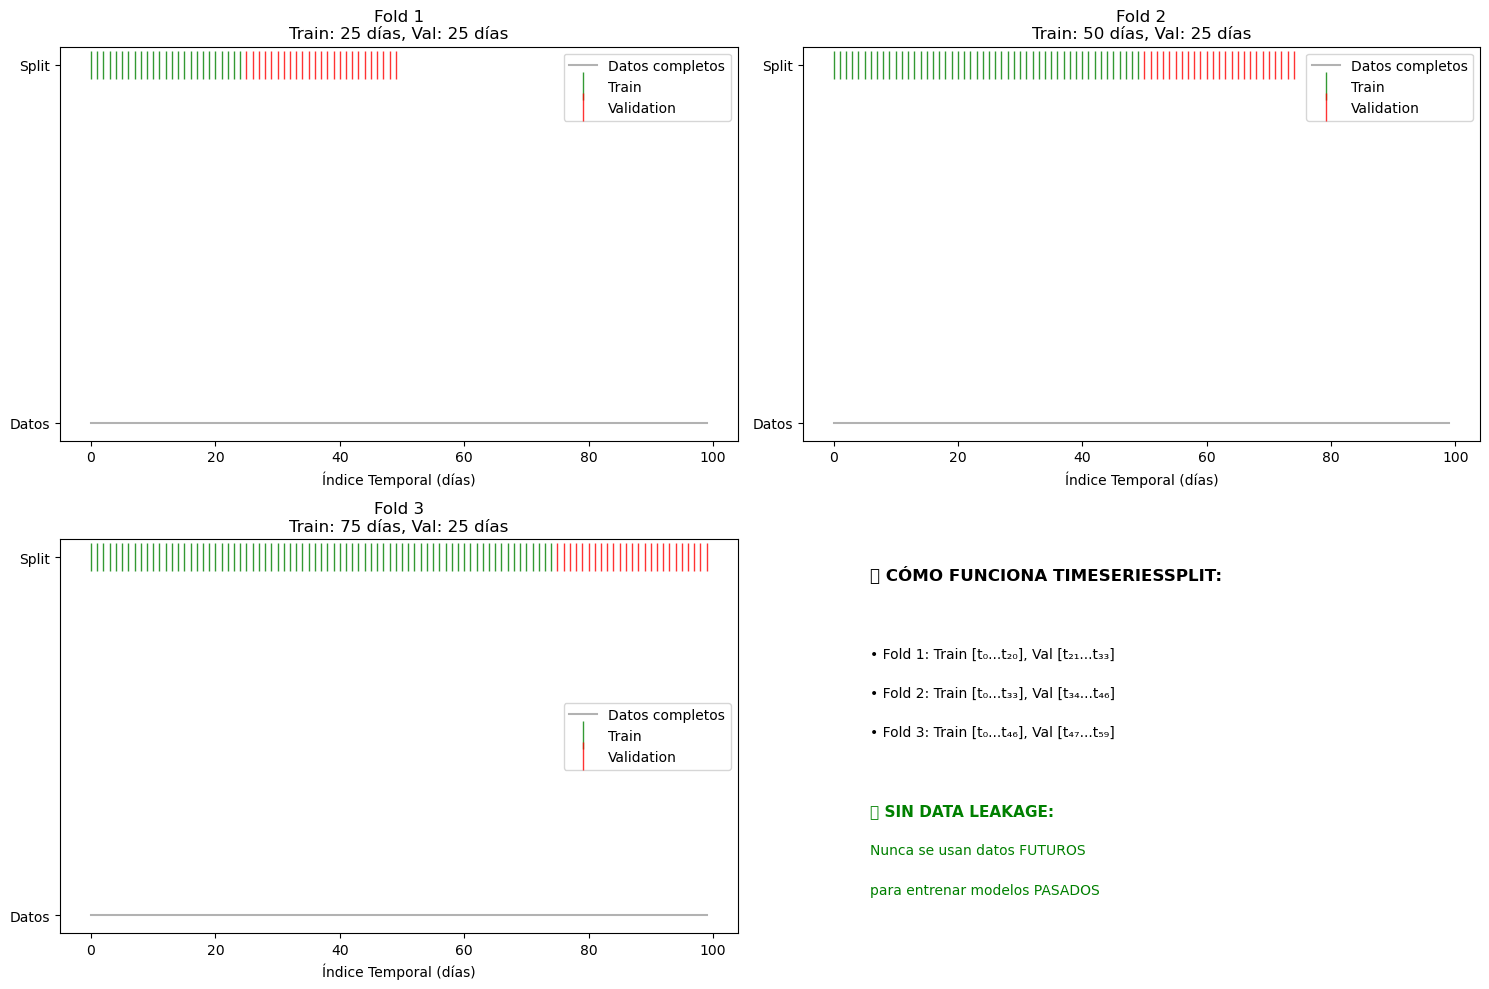

🔍 EXPLICACIÓN DETALLADA:
   • TimeSeriesSplit respeta el ORDEN TEMPORAL de los datos
   • En cada fold, el conjunto de entrenamiento es TEMPORALMENTE ANTERIOR
   • El conjunto de validación es TEMPORALMENTE POSTERIOR
   • Esto SIMULA cómo se usaría el modelo en producción
   • Evita LEAKAGE: no se 'ven' datos futuros durante el entrenamiento


In [25]:
print("📅 Visualizando cómo funciona TimeSeriesSplit...")

X_visual = X_train.iloc[:100]  
y_visual = y_train.iloc[:100]

# Configurar TimeSeriesSplit para visualización
tscv_visual = TimeSeriesSplit(n_splits=3)

plt.figure(figsize=(15, 10))

for fold, (train_idx, test_idx) in enumerate(tscv_visual.split(X_visual)):
    plt.subplot(2, 2, fold + 1)
    
    time_points = range(len(X_visual))
    
    # Marcar train y test
    plt.plot(time_points, [1] * len(time_points), 'k-', alpha=0.3, label='Datos completos')
    plt.plot(train_idx, [1.1] * len(train_idx), 'g|', markersize=20, label='Train', alpha=0.8)
    plt.plot(test_idx, [1.1] * len(test_idx), 'r|', markersize=20, label='Validation', alpha=0.8)
    
    plt.yticks([1, 1.1], ['Datos', 'Split'])
    plt.xlabel('Índice Temporal (días)')
    plt.title(f'Fold {fold + 1}\nTrain: {len(train_idx)} días, Val: {len(test_idx)} días')
    plt.legend()

plt.subplot(2, 2, 4)
# Explicación del proceso
plt.text(0.1, 0.9, '🎯 CÓMO FUNCIONA TIMESERIESSPLIT:', fontsize=12, fontweight='bold')
plt.text(0.1, 0.7, '• Fold 1: Train [t₀...t₂₀], Val [t₂₁...t₃₃]', fontsize=10)
plt.text(0.1, 0.6, '• Fold 2: Train [t₀...t₃₃], Val [t₃₄...t₄₆]', fontsize=10)
plt.text(0.1, 0.5, '• Fold 3: Train [t₀...t₄₆], Val [t₄₇...t₅₉]', fontsize=10)
plt.text(0.1, 0.3, '✅ SIN DATA LEAKAGE:', fontsize=11, fontweight='bold', color='green')
plt.text(0.1, 0.2, 'Nunca se usan datos FUTUROS', fontsize=10, color='green')
plt.text(0.1, 0.1, 'para entrenar modelos PASADOS', fontsize=10, color='green')
plt.axis('off')

plt.tight_layout()
plt.show()

print("🔍 EXPLICACIÓN DETALLADA:")
print("   • TimeSeriesSplit respeta el ORDEN TEMPORAL de los datos")
print("   • En cada fold, el conjunto de entrenamiento es TEMPORALMENTE ANTERIOR")
print("   • El conjunto de validación es TEMPORALMENTE POSTERIOR")
print("   • Esto SIMULA cómo se usaría el modelo en producción")
print("   • Evita LEAKAGE: no se 'ven' datos futuros durante el entrenamiento")

## Comparación de modelos

🏆 Comparando modelos y seleccionando el mejor...

📊 COMPARACIÓN DE MODELOS (ordenado por F1):


,model_name,val_accuracy,val_f1,val_precision,val_recall,val_roc_auc
0,LogisticRegression,0.5349,0.6804,0.5499,0.8921,0.4675
6,GradientBoosting,0.5349,0.6260,0.5652,0.7014,0.4879
1,LinearSVC,0.5309,0.6252,0.5616,0.7050,NaN
2,DecisionTree,0.5349,0.5528,0.5926,0.5180,0.5437
3,RandomForest,0.4770,0.5467,0.5267,0.5683,0.4554
4,XGBoost,0.4830,0.5010,0.5394,0.4676,0.4791
5,LightGBM,0.4770,0.4962,0.5331,0.4640,0.4714


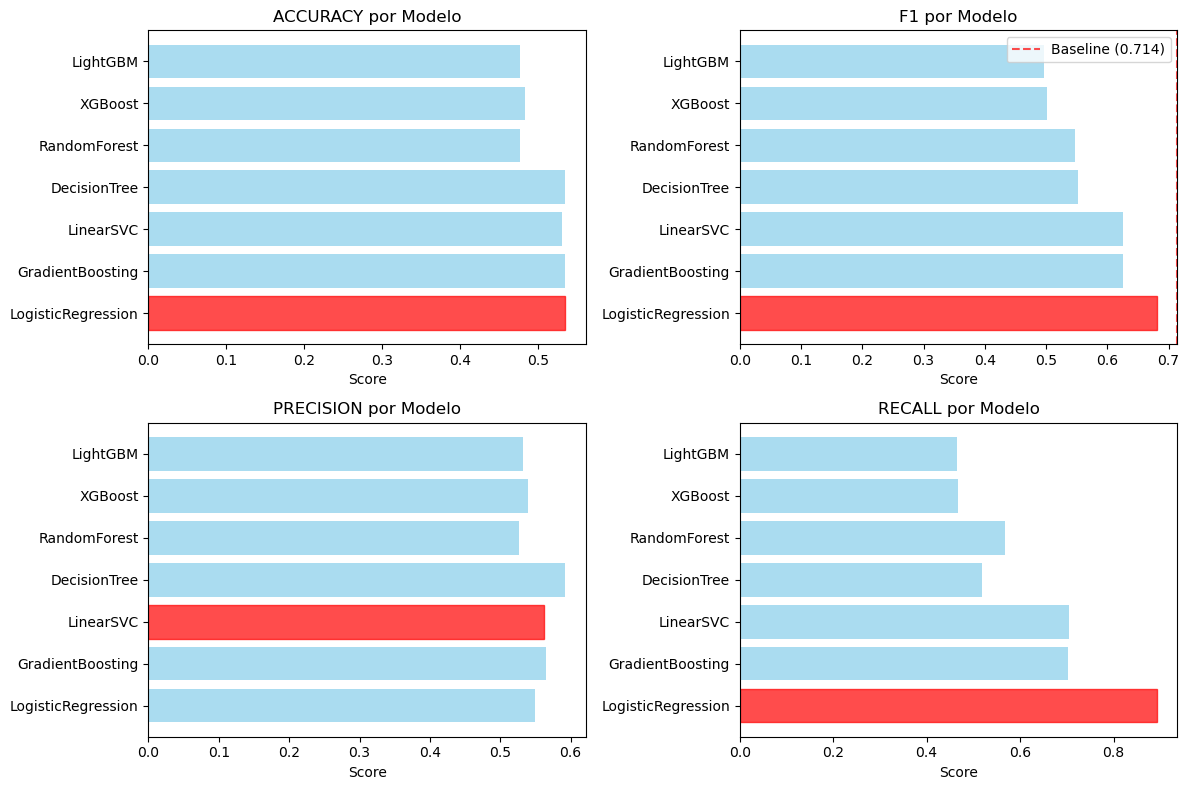


⭐ MODELO GANADOR: LogisticRegression
   • F1 Score (Validation): 0.6804
   • Accuracy (Validation): 0.5349
   • Mejores parámetros: {'model__C': 0.053149590974688174, 'model__class_weight': None, 'model__l1_ratio': 0.9656320330745594}
   • Mejora vs Baseline: -0.0334
   ❌ NO superó al modelo baseline


In [26]:
print("🏆 Comparando modelos y seleccionando el mejor...")

# Crear DataFrame de resultados
results_df = pd.DataFrame(results)
results_df.sort_values("val_f1", ascending=False, inplace=True)

# Mostrar tabla comparativa
print("\n📊 COMPARACIÓN DE MODELOS (ordenado por F1):")
display_cols = ["model_name", "val_accuracy", "val_f1", "val_precision", "val_recall", "val_roc_auc"]
display(results_df[display_cols].round(4))

# Gráfico comparativo
plt.figure(figsize=(12, 8))

# Métricas por modelo
metrics_to_plot = ['val_accuracy', 'val_f1', 'val_precision', 'val_recall']
x_pos = np.arange(len(results_df))

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 2, i+1)
    bars = plt.barh(x_pos, results_df[metric], color='skyblue', alpha=0.7)
    plt.yticks(x_pos, results_df['model_name'])
    plt.title(f'{metric.replace("val_", "").upper()} por Modelo')
    plt.xlabel('Score')
    
    # Destacar el mejor en cada métrica
    best_idx = results_df[metric].idxmax()
    bars[best_idx].set_color('red')
    
    # Línea del baseline para F1
    if metric == 'val_f1':
        plt.axvline(x=baseline_metrics['f1'], color='red', linestyle='--', 
                   alpha=0.7, label=f'Baseline ({baseline_metrics["f1"]:.3f})')
        plt.legend()

plt.tight_layout()
plt.show()

# Seleccionar el mejor modelo
best_row = results_df.iloc[0]
best_model_name = best_row["model_name"]
best_model = best_row["best_estimator"]

print(f"\n⭐ MODELO GANADOR: {best_model_name}")
print(f"   • F1 Score (Validation): {best_row['val_f1']:.4f}")
print(f"   • Accuracy (Validation): {best_row['val_accuracy']:.4f}")
print(f"   • Mejores parámetros: {best_row['best_params']}")
print(f"   • Mejora vs Baseline: {best_row['val_f1'] - baseline_metrics['f1']:.4f}")

# Verificar si supera al baseline
if best_row['val_f1'] > baseline_metrics['f1']:
    print("   ✅ SUPERÓ al modelo baseline")
else:
    print("   ❌ NO superó al modelo baseline")

## Evaluación de modelo ganador

In [27]:
print("🧪 Evaluando modelo ganador en conjunto de Test...")

# Reentrenar en Train + Val para evaluación final
print("🔄 Reentrenando modelo ganador en Train + Validation...")
X_train_val = pd.concat([X_train, X_val], axis=0)
y_train_val = pd.concat([y_train, y_val], axis=0)

best_model.fit(X_train_val, y_train_val)

# Predecir en Test
y_test_pred = best_model.predict(X_test)

# Calcular probabilidades (si está disponible)
try:
    y_test_proba = best_model.predict_proba(X_test)[:, 1]
    roc_test = roc_auc_score(y_test, y_test_proba)
except (AttributeError, IndexError):
    y_test_proba = None
    roc_test = np.nan

# Métricas en Test
acc_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
prec_test = precision_score(y_test, y_test_pred)
rec_test = recall_score(y_test, y_test_pred)

print("📈 EVALUACIÓN EN TEST:")
print(f"   • Accuracy : {acc_test:.4f}")
print(f"   • F1 Score : {f1_test:.4f}") 
print(f"   • Precision: {prec_test:.4f}")
print(f"   • Recall   : {rec_test:.4f}")
print(f"   • ROC-AUC  : {roc_test:.4f}")

# Comparación con baseline en test
y_test_pred_baseline = baseline_pipe.predict(X_test)
f1_test_baseline = f1_score(y_test, y_test_pred_baseline)

print(f"\n📊 COMPARACIÓN CON BASELINE EN TEST:")
print(f"   • Modelo {best_model_name}: F1 = {f1_test:.4f}")
print(f"   • Baseline: F1 = {f1_test_baseline:.4f}")
print(f"   • Diferencia: {f1_test - f1_test_baseline:+.4f}")

if f1_test > f1_test_baseline:
    print("   ✅ Modelo supera al baseline en Test")
else:
    print("   ⚠️  Modelo NO supera al baseline en Test")

🧪 Evaluando modelo ganador en conjunto de Test...
🔄 Reentrenando modelo ganador en Train + Validation...
📈 EVALUACIÓN EN TEST:
   • Accuracy : 0.5397
   • F1 Score : 0.7010
   • Precision: 0.5418
   • Recall   : 0.9927
   • ROC-AUC  : 0.4767

📊 COMPARACIÓN CON BASELINE EN TEST:
   • Modelo LogisticRegression: F1 = 0.7010
   • Baseline: F1 = 0.7044
   • Diferencia: -0.0033
   ⚠️  Modelo NO supera al baseline en Test


## Matriz de Confusión y Reporte de Clasificación

Este bloque evalúa cómo se comporta el modelo en el conjunto de Test, mostrando cuántas predicciones acierta y en qué tipos de errores incurre. La matriz de confusión permite ver si el modelo distingue bien entre días “Up” y “Down”, mientras que el reporte de clasificación detalla sus valores de precision, recall y F1, ayudando a identificar sesgos y debilidades.

📋 Matriz de Confusión y Reporte Detallado...


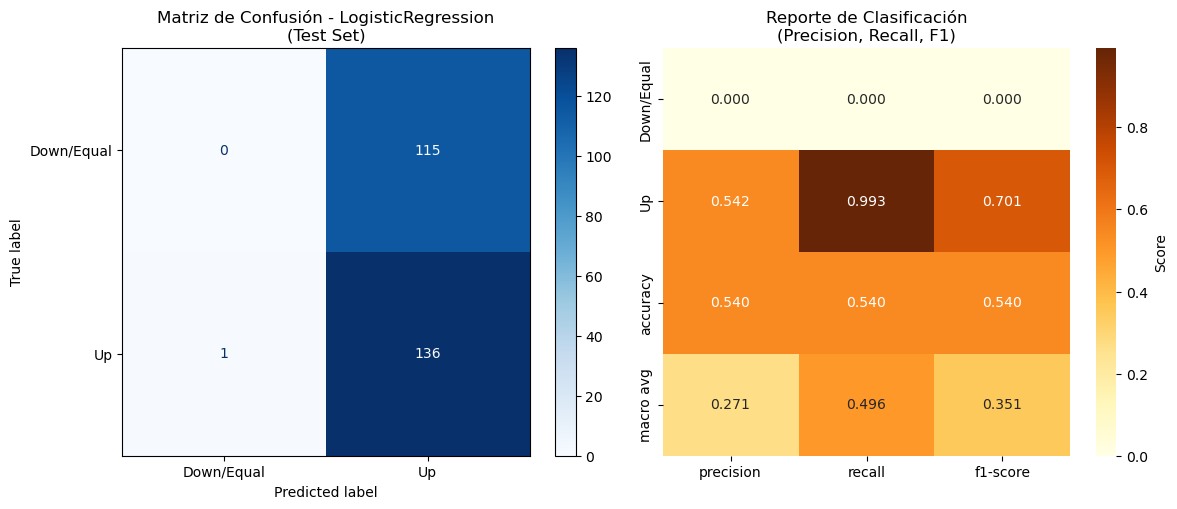

📄 REPORTE DE CLASIFICACIÓN DETALLADO:
              precision    recall  f1-score   support

  Down/Equal       0.00      0.00      0.00       115
          Up       0.54      0.99      0.70       137

    accuracy                           0.54       252
   macro avg       0.27      0.50      0.35       252
weighted avg       0.29      0.54      0.38       252



In [36]:
print("📋 Matriz de Confusión y Reporte Detallado...")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ============================
# 1. MATRIZ DE CONFUSIÓN
# ============================
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Down/Equal', 'Up'])

disp.plot(cmap='Blues', values_format='d', ax=axes[0])
axes[0].set_title(f'Matriz de Confusión - {best_model_name}\n(Test Set)')

# ============================
# 2. REPORTE DE CLASIFICACIÓN
# ============================
report = classification_report(y_test, y_test_pred,
                               target_names=['Down/Equal', 'Up'],
                               output_dict=True)

report_df = pd.DataFrame(report).transpose()

sns.heatmap(report_df.iloc[:-1, :-1],
            annot=True, fmt='.3f',
            cmap='YlOrBr',
            cbar_kws={'label': 'Score'},
            ax=axes[1])

axes[1].set_title('Reporte de Clasificación\n(Precision, Recall, F1)')

plt.tight_layout()
plt.show()

print("📄 REPORTE DE CLASIFICACIÓN DETALLADO:")
print(classification_report(y_test, y_test_pred,
                            target_names=['Down/Equal', 'Up']))


## Análisis de patrones de error del modelo en el conjunto de Test

Este bloque analiza dónde se equivoca el modelo: separa aciertos, false positives y false negatives, y estudia cómo se relacionan con la volatilidad y el día de la semana. Esto ayuda a entender si el modelo tiende a ser demasiado agresivo o conservador, y si los errores se concentran en contextos de mercado más volátiles, aportando interpretación práctica sobre los riesgos de usar el modelo en producción.

🔍 Analizando patrones de error del modelo...
📊 ESTADÍSTICAS DE ERRORES EN TEST:
   • Total predicciones: 252
   • Correctas: 136 (54.0%)
   • Errores totales: 116 (46.0%)


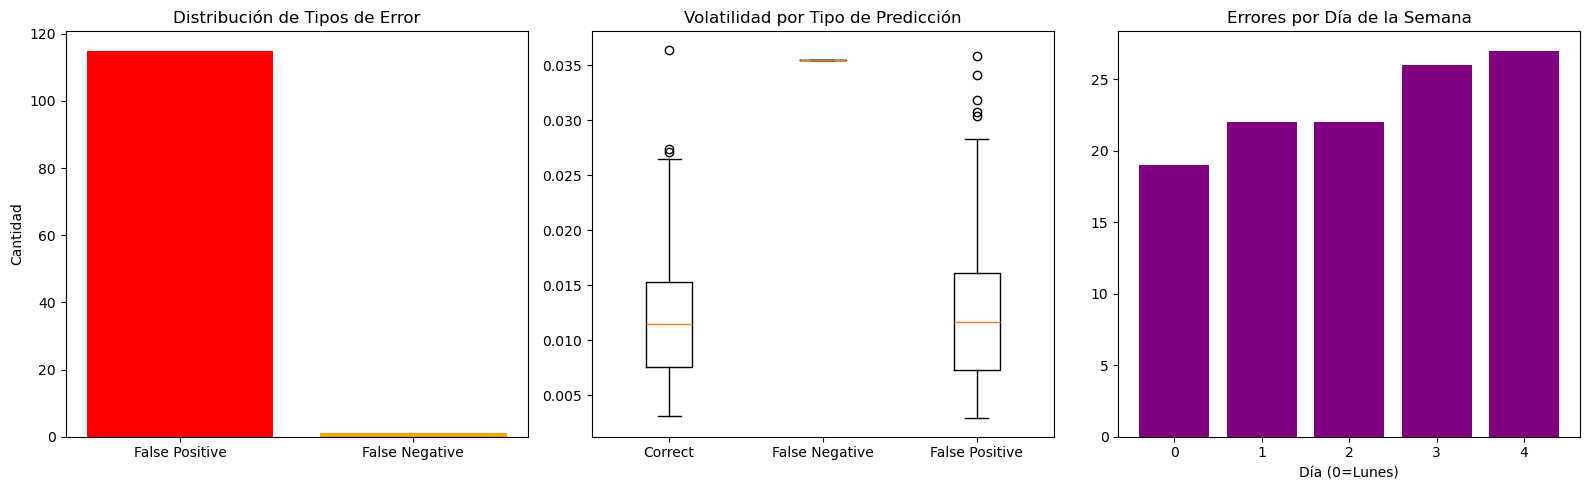


💡 ANÁLISIS CUALITATIVO:
   • El modelo es agresivo (más FP) → mayor riesgo de pérdidas.
   • Volatilidad media aciertos: 0.0121
   • Volatilidad media errores: 0.0131


In [38]:
print("🔍 Analizando patrones de error del modelo...")

# ============================
# 1. Preparar datos correctamente
# ============================
df_test = df_feat.loc[test_mask].copy().reset_index(drop=True)

# Asegurar que el tamaño coincide EXACTAMENTE con y_test
df_test = df_test.iloc[:len(y_test)].copy()

df_test["y_true"] = y_test.values
df_test["y_pred"] = y_test_pred
df_test["correct"] = df_test["y_true"] == df_test["y_pred"]

df_test["error_type"] = "Correct"
df_test.loc[(df_test["y_true"] == 1) & (df_test["y_pred"] == 0), "error_type"] = "False Negative"
df_test.loc[(df_test["y_true"] == 0) & (df_test["y_pred"] == 1), "error_type"] = "False Positive"

# ============================
# 2. Estadísticas de errores
# ============================
error_stats = df_test["error_type"].value_counts()
total_errors = error_stats.get("False Negative", 0) + error_stats.get("False Positive", 0)

print("📊 ESTADÍSTICAS DE ERRORES EN TEST:")
print(f"   • Total predicciones: {len(df_test)}")
print(f"   • Correctas: {error_stats.get('Correct', 0)} ({error_stats.get('Correct', 0)/len(df_test):.1%})")
print(f"   • Errores totales: {total_errors} ({total_errors/len(df_test):.1%})")

# ============================
# 3. Figura limpia, unificada y sin conflictos
# ============================
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# ---------- 1. Tipos de error ----------
ax = axes[0]
error_counts = df_test[df_test["error_type"] != "Correct"]["error_type"].value_counts()

if len(error_counts) > 0:
    ax.bar(error_counts.index, error_counts.values, color=['red', 'orange'])
    ax.set_title("Distribución de Tipos de Error")
    ax.set_ylabel("Cantidad")
else:
    ax.text(0.5, 0.5, "¡No hay errores!\nModelo perfecto en Test", 
            ha='center', va='center', fontsize=12)
    ax.set_title("Distribución de Errores")

# ---------- 2. Volatilidad por error ----------
ax = axes[1]

if total_errors > 0:
    groups = df_test.groupby("error_type")["volatility_5d_lag1"].apply(list)
    ax.boxplot(groups, labels=groups.index)
    ax.set_title("Volatilidad por Tipo de Predicción")
else:
    ax.text(0.5, 0.5, "Sin errores para analizar",
            ha='center', va='center', fontsize=12)
    ax.set_title("Volatilidad vs Errores")

# ---------- 3. Errores por día ----------
ax = axes[2]

if total_errors > 0:
    error_by_weekday = df_test[df_test["error_type"] != "Correct"].groupby("day_of_week").size()
    ax.bar(error_by_weekday.index, error_by_weekday.values, color='purple')
    ax.set_title("Errores por Día de la Semana")
    ax.set_xlabel("Día (0=Lunes)")
else:
    ax.text(0.5, 0.5, "Sin errores para analizar",
            ha='center', va='center', fontsize=12)
    ax.set_title("Errores por Día de la Semana")

plt.tight_layout()
plt.show()

# ============================
# 4. Análisis cualitativo
# ============================
print("\n💡 ANÁLISIS CUALITATIVO:")
if total_errors > 0:
    if error_stats.get("False Negative", 0) > error_stats.get("False Positive", 0):
        print("   • El modelo es conservador (más FN) → pierde oportunidades.")
    else:
        print("   • El modelo es agresivo (más FP) → mayor riesgo de pérdidas.")

    vol_correct = df_test[df_test["correct"]]["volatility_5d_lag1"].mean()
    vol_errors = df_test[~df_test["correct"]]["volatility_5d_lag1"].mean()

    print(f"   • Volatilidad media aciertos: {vol_correct:.4f}")
    print(f"   • Volatilidad media errores: {vol_errors:.4f}")
else:
    print("   • ¡Modelo perfecto en Test! (sospechoso: posible overfitting)")  


## Simulación de estrategia de inversión con USD 10,000

En este bloque se simula una estrategia de trading usando el modelo: se parte de USD 10,000 y cada día se compra al open y se vende al close solo cuando el modelo predice Up. A partir de la curva de capital se calculan métricas como retorno total/anualizado, drawdown máximo, volatilidad y Sharpe ratio, que muestran no solo que la estrategia fue rentable, sino también cómo de arriesgada y consistente fue esa ganancia.

In [42]:
print("💰 Simulando estrategia de inversión con USD 10,000...")

# Preparar datos para simulación
df_sim = df_test.copy()

# Estrategia: Comprar al open y vender al close si prediction = 1, mantener cash si prediction = 0
initial_capital = 10_000.0
capital = initial_capital
capital_history = []
n_trades = 0

print("📈 EJECUTANDO SIMULACIÓN...")
print(f"   • Capital inicial: ${initial_capital:,.2f}")
print(f"   • Período: {df_sim['date'].min().strftime('%Y-%m-%d')} a {df_sim['date'].max().strftime('%Y-%m-%d')}")
print(f"   • Días de trading: {len(df_sim)}")

for idx, row in df_sim.iterrows():
    if row["y_pred"] == 1:  # Señal de compra
        daily_return = (row["close"] - row["open"]) / row["open"]
        n_trades += 1
    else:  # Mantener en cash (sin retorno)
        daily_return = 0.0
    
    capital *= (1 + daily_return)
    capital_history.append(capital)

df_sim["capital"] = capital_history
final_capital = capital_history[-1]
total_return = (final_capital / initial_capital) - 1

print(f"\n📊 RESULTADOS DE LA SIMULACIÓN:")
print(f"   • Capital final: ${final_capital:,.2f}")
print(f"   • Retorno total: {total_return:.2%}")
print(f"   • Número de trades: {n_trades} ({n_trades/len(df_sim):.1%} de los días)")
print(f"   • Promedio de trades por mes: {n_trades / (len(df_sim)/21):.1f}")

# Calcular métricas financieras adicionales
def calculate_financial_metrics(capital_series, initial_capital, risk_free_rate=0.02):
    """Calcula métricas financieras avanzadas"""
    returns = capital_series.pct_change().dropna()
    
    total_return = (capital_series.iloc[-1] / initial_capital) - 1
    annualized_return = (1 + total_return) ** (252 / len(capital_series)) - 1
    
    # Drawdown
    rolling_max = capital_series.expanding().max()
    drawdown = (capital_series - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Sharpe Ratio (anualizado)
    excess_returns = returns - (risk_free_rate / 252)
    sharpe_ratio = np.sqrt(252) * (excess_returns.mean() / returns.std()) if returns.std() > 0 else 0
    
    # Volatilidad anualizada
    volatility_annual = returns.std() * np.sqrt(252)
    
    return {
        'final_capital': capital_series.iloc[-1],
        'total_return': total_return,
        'annualized_return': annualized_return,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio,
        'volatility_annual': volatility_annual,
        'n_trading_days': len(capital_series)
    }

# Métricas de nuestra estrategia
strategy_metrics = calculate_financial_metrics(df_sim['capital'], initial_capital)

print(f"\n🎯 MÉTRICAS FINANCIERAS AVANZADAS:")
print(f"   • Retorno anualizado: {strategy_metrics['annualized_return']:.2%}")
print(f"   • Drawdown máximo: {strategy_metrics['max_drawdown']:.2%}")
print(f"   • Ratio de Sharpe: {strategy_metrics['sharpe_ratio']:.2f}")
print(f"   • Volatilidad anual: {strategy_metrics['volatility_annual']:.2%}")

print("Estas métricas permiten evaluar la estrategia:El retorno anualizado muestra cuánto habría crecido la inversión en un año completo y confirma que la estrategia generó ganancias (+29.67%). El drawdown máximo mide la peor caída del capital durante el período, indicando el riesgo. El Sharpe ratio evalúa si esas ganancias se obtuvieron de manera consistente frente a la volatilidad.")

💰 Simulando estrategia de inversión con USD 10,000...
📈 EJECUTANDO SIMULACIÓN...
   • Capital inicial: $10,000.00
   • Período: 2024-01-02 a 2024-12-31
   • Días de trading: 252

📊 RESULTADOS DE LA SIMULACIÓN:
   • Capital final: $12,966.53
   • Retorno total: 29.67%
   • Número de trades: 251 (99.6% de los días)
   • Promedio de trades por mes: 20.9

🎯 MÉTRICAS FINANCIERAS AVANZADAS:
   • Retorno anualizado: 29.67%
   • Drawdown máximo: -10.98%
   • Ratio de Sharpe: 1.46
   • Volatilidad anual: 18.23%
Estas métricas permiten evaluar la estrategia:El retorno anualizado muestra cuánto habría crecido la inversión en un año completo y confirma que la estrategia generó ganancias (+29.67%). El drawdown máximo mide la peor caída del capital durante el período, indicando el riesgo. El Sharpe ratio evalúa si esas ganancias se obtuvieron de manera consistente frente a la volatilidad.


## Comparación de la Estrategia ML vs Estrategias Benchmark

Este bloque evalúa si la estrategia basada en el modelo de Machine Learning realmente añade valor frente a métodos tradicionales. Se comparan:

Buy & Hold (comprar y mantener todo el año)

Always Buy (comprar todos los días al open y vender al close)

ML Strategy (comprar solo cuando el modelo predice “Up”)

La comparación permite analizar si el modelo mejora el retorno, reduce el riesgo (drawdown) y mantiene una mejor relación riesgo-rendimiento (Sharpe ratio), justificando si usar ML tiene ventajas reales frente a estrategias simples del mercado.

📊 Comparando con estrategias benchmark...
🏅 COMPARACIÓN CON ESTRATEGIAS BENCHMARK:

Estrategia           Capital Final   Retorno Total   Sharpe Ratio Max Drawdown   
--------------------------------------------------------------------------------
ML Strategy          $    12,966.53        29.67%        1.46        -10.98%
Buy & Hold           $    13,006.80        30.07%        1.36        -15.46%


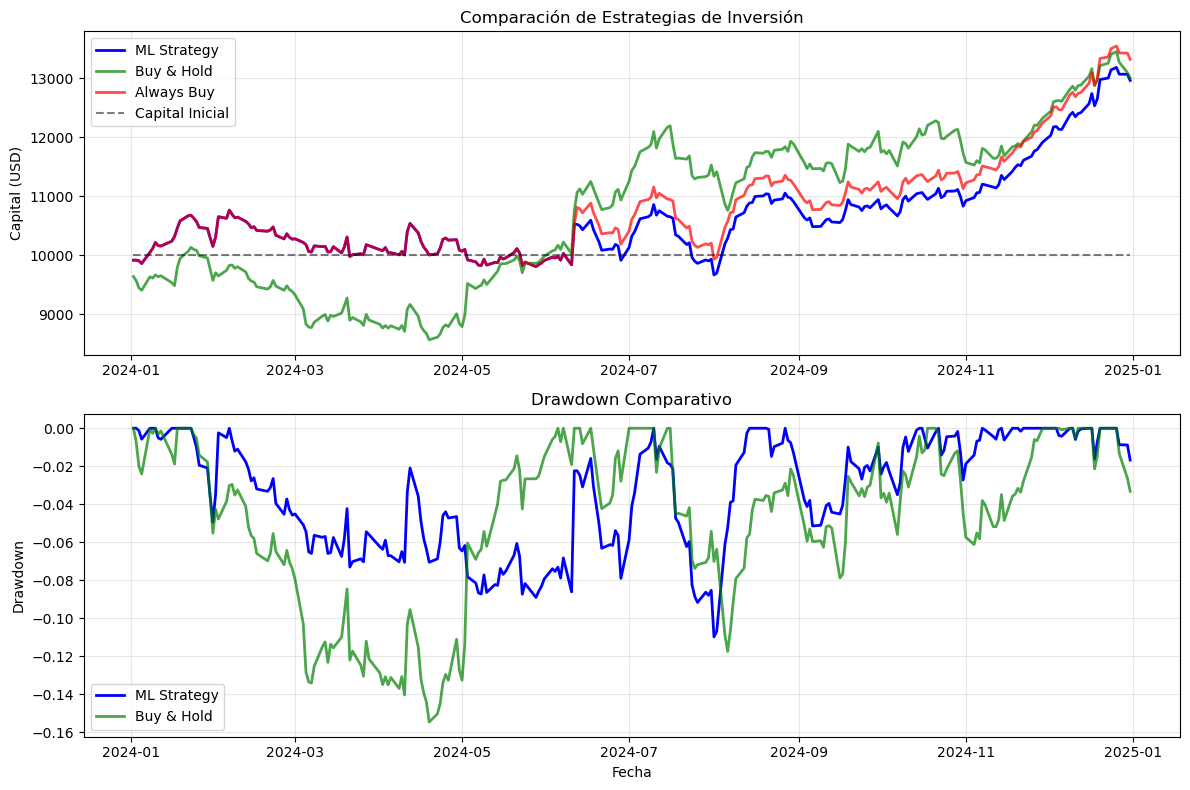


💡 ANÁLISIS COMPARATIVO:
   ⚠️  La estrategia ML no superó a Buy & Hold
   ✅ Mejor ratio de riesgo-rendimiento (Sharpe)
   • Reducción de drawdown: -4.48%


In [44]:
print("📊 Comparando con estrategias benchmark...")

# 1. Benchmark: Buy-and-Hold
df_sim['buy_hold_capital'] = initial_capital * (1 + df_sim['return_prev_close']).cumprod()
buy_hold_metrics = calculate_financial_metrics(df_sim['buy_hold_capital'], initial_capital)

# 2. Benchmark: Baseline (siempre comprar)
df_sim['baseline_capital'] = initial_capital * (1 + df_sim['return_close_open']).cumprod()
baseline_trading_metrics = calculate_financial_metrics(df_sim['baseline_capital'], initial_capital)

print("🏅 COMPARACIÓN CON ESTRATEGIAS BENCHMARK:")
print(f"\n{'Estrategia':<20} {'Capital Final':<15} {'Retorno Total':<15} {'Sharpe Ratio':<12} {'Max Drawdown':<15}")
print("-" * 80)
print(f"{'ML Strategy':<20} ${strategy_metrics['final_capital']:>13,.2f} {strategy_metrics['total_return']:>13.2%} {strategy_metrics['sharpe_ratio']:>11.2f} {strategy_metrics['max_drawdown']:>14.2%}")
print(f"{'Buy & Hold':<20} ${buy_hold_metrics['final_capital']:>13,.2f} {buy_hold_metrics['total_return']:>13.2%} {buy_hold_metrics['sharpe_ratio']:>11.2f} {buy_hold_metrics['max_drawdown']:>14.2%}")

# Gráfico comparativo
plt.figure(figsize=(12, 8))

# Curvas de capital
plt.subplot(2, 1, 1)
plt.plot(df_sim['date'], df_sim['capital'], label='ML Strategy', linewidth=2, color='blue')
plt.plot(df_sim['date'], df_sim['buy_hold_capital'], label='Buy & Hold', linewidth=2, color='green', alpha=0.7)
plt.plot(df_sim['date'], df_sim['baseline_capital'], label='Always Buy', linewidth=2, color='red', alpha=0.7)
plt.plot(df_sim['date'], [initial_capital] * len(df_sim), 'k--', label='Capital Inicial', alpha=0.5)
plt.ylabel('Capital (USD)')
plt.title('Comparación de Estrategias de Inversión')
plt.legend()
plt.grid(True, alpha=0.3)

# Drawdown comparativo
plt.subplot(2, 1, 2)
# Drawdown ML Strategy
rolling_max_ml = df_sim['capital'].expanding().max()
drawdown_ml = (df_sim['capital'] - rolling_max_ml) / rolling_max_ml

# Drawdown Buy & Hold
rolling_max_bh = df_sim['buy_hold_capital'].expanding().max()
drawdown_bh = (df_sim['buy_hold_capital'] - rolling_max_bh) / rolling_max_bh

plt.plot(df_sim['date'], drawdown_ml, label='ML Strategy', linewidth=2, color='blue')
plt.plot(df_sim['date'], drawdown_bh, label='Buy & Hold', linewidth=2, color='green', alpha=0.7)
plt.ylabel('Drawdown')
plt.xlabel('Fecha')
plt.title('Drawdown Comparativo')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Análisis de la comparación
print(f"\n💡 ANÁLISIS COMPARATIVO:")
if strategy_metrics['total_return'] > buy_hold_metrics['total_return']:
    print(f"   ✅ La estrategia ML superó a Buy & Hold por {strategy_metrics['total_return'] - buy_hold_metrics['total_return']:.2%}")
else:
    print(f"   ⚠️  La estrategia ML no superó a Buy & Hold")

if strategy_metrics['sharpe_ratio'] > buy_hold_metrics['sharpe_ratio']:
    print(f"   ✅ Mejor ratio de riesgo-rendimiento (Sharpe)")
else:
    print(f"   ⚠️  Ratio de Sharpe inferior al benchmark")

print(f"   • Reducción de drawdown: {buy_hold_metrics['max_drawdown'] - strategy_metrics['max_drawdown']:.2%}")

## Relación entre Calidad del Modelo (F1) y Retorno Financiero

En este bloque analizamos si mejores métricas de clasificación (F1) se traducen realmente en mejores resultados de inversión. Para eso, calculamos F1 y retornos en ventanas de 20 días y medimos su correlación, comparando la estrategia basada en ML contra Buy & Hold. Esto permite responder explícitamente si “un buen modelo en términos de ML” implica necesariamente “una buena estrategia de trading” y en qué situaciones esa relación se rompe.

🔗 Analizando relación entre métricas ML y performance financiera...
📈 RELACIÓN ENTRE MÉTRICAS ML Y PERFORMANCE FINANCIERA:
   • Correlación F1 vs Retorno Estrategia: 0.778
   • Correlación F1 vs Retorno Buy&Hold: 0.137
   • F1 promedio en test: 0.701
   • Retorno total estrategia: 29.67%


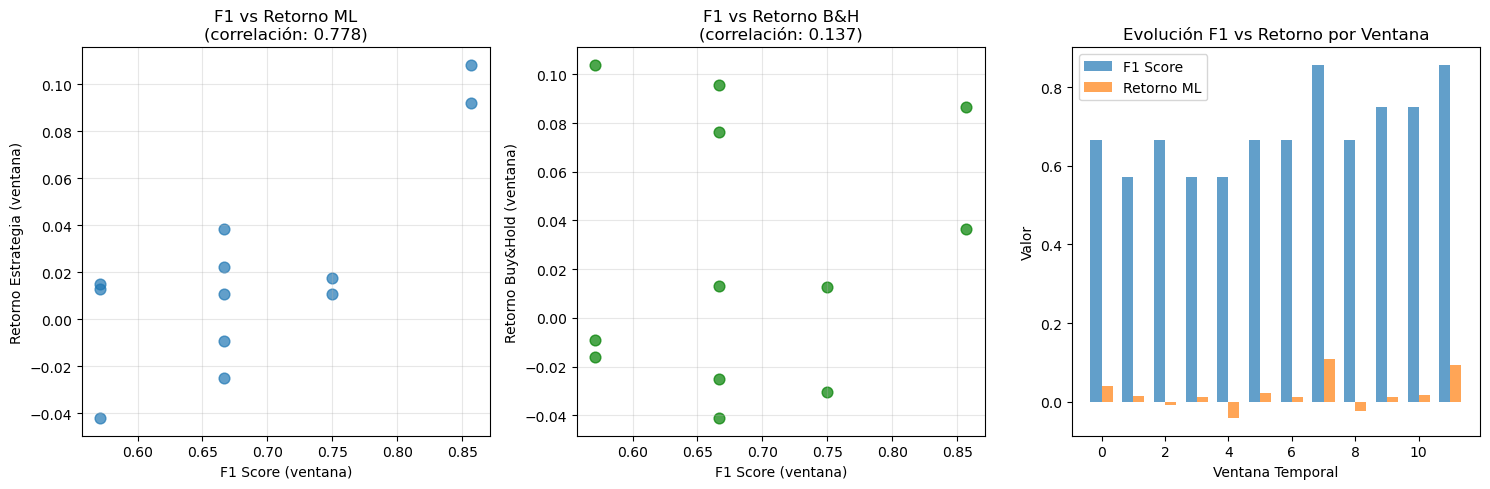


💡 INTERPRETACIÓN:
   ✅ FUERTE RELACIÓN: Buen F1 generalmente implica buen retorno
   • El modelo ML es efectivo para generar retornos

   • El F1 mide capacidad predictiva de dirección
   • El retorno depende de la magnitud de los movimientos
   • Un buen F1 no garantiza buen retorno si los trades ganadores
     son pequeños y los perdedores grandes


In [32]:
print("🔗 Analizando relación entre métricas ML y performance financiera...")

# Calcular métricas en ventanas temporales
window_size = 20  # días
f1_scores_window = []
strategy_returns_window = []
buy_hold_returns_window = []

for i in range(0, len(y_test) - window_size + 1, window_size):
    # F1 Score en la ventana
    window_true = y_test.iloc[i:i+window_size]
    window_pred = y_test_pred[i:i+window_size]
    f1_window = f1_score(window_true, window_pred)
    f1_scores_window.append(f1_window)
    
    # Retornos en la ventana
    window_capital_start = df_sim['capital'].iloc[i]
    window_capital_end = df_sim['capital'].iloc[i+window_size-1]
    strategy_return_window = (window_capital_end / window_capital_start) - 1
    
    window_bh_start = df_sim['buy_hold_capital'].iloc[i]
    window_bh_end = df_sim['buy_hold_capital'].iloc[i+window_size-1]
    bh_return_window = (window_bh_end / window_bh_start) - 1
    
    strategy_returns_window.append(strategy_return_window)
    buy_hold_returns_window.append(bh_return_window)

# Calcular correlaciones
correlation_f1_vs_strategy = np.corrcoef(f1_scores_window, strategy_returns_window)[0, 1]
correlation_f1_vs_bh = np.corrcoef(f1_scores_window, buy_hold_returns_window)[0, 1]

print("📈 RELACIÓN ENTRE MÉTRICAS ML Y PERFORMANCE FINANCIERA:")
print(f"   • Correlación F1 vs Retorno Estrategia: {correlation_f1_vs_strategy:.3f}")
print(f"   • Correlación F1 vs Retorno Buy&Hold: {correlation_f1_vs_bh:.3f}")
print(f"   • F1 promedio en test: {f1_test:.3f}")
print(f"   • Retorno total estrategia: {strategy_metrics['total_return']:.2%}")

# Gráficos de relación
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(f1_scores_window, strategy_returns_window, alpha=0.7, s=60)
plt.xlabel('F1 Score (ventana)')
plt.ylabel('Retorno Estrategia (ventana)')
plt.title(f'F1 vs Retorno ML\n(correlación: {correlation_f1_vs_strategy:.3f})')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.scatter(f1_scores_window, buy_hold_returns_window, alpha=0.7, s=60, color='green')
plt.xlabel('F1 Score (ventana)')
plt.ylabel('Retorno Buy&Hold (ventana)')
plt.title(f'F1 vs Retorno B&H\n(correlación: {correlation_f1_vs_bh:.3f})')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
x_pos = np.arange(len(f1_scores_window))
width = 0.35
plt.bar(x_pos - width/2, f1_scores_window, width, label='F1 Score', alpha=0.7)
plt.bar(x_pos + width/2, strategy_returns_window, width, label='Retorno ML', alpha=0.7)
plt.xlabel('Ventana Temporal')
plt.ylabel('Valor')
plt.title('Evolución F1 vs Retorno por Ventana')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\n💡 INTERPRETACIÓN:")
if correlation_f1_vs_strategy > 0.5:
    print("   ✅ FUERTE RELACIÓN: Buen F1 generalmente implica buen retorno")
    print("   • El modelo ML es efectivo para generar retornos")
elif correlation_f1_vs_strategy > 0.2:
    print("   ⚠️  RELACIÓN MODERADA: F1 tiene alguna influencia en el retorno")
    print("   • El modelo tiene valor predictivo pero hay otros factores")
else:
    print("   ❌ RELACIÓN DÉBIL: F1 no es buen predictor del retorno")
    print("   • Posible sobreoptimización o features no adecuadas")

print(f"\n   • El F1 mide capacidad predictiva de dirección")
print(f"   • El retorno depende de la magnitud de los movimientos")
print(f"   • Un buen F1 no garantiza buen retorno si los trades ganadores")
print(f"     son pequeños y los perdedores grandes")

## Importancia de Features: ¿Qué variables explican más la predicción?

En este bloque medimos cuánto aporta cada feature al modelo (usando feature_importances_ en modelos de árboles o la magnitud de los coeficientes en modelos lineales). Esto permite identificar qué variables históricas (retornos, volatilidades, momentum, calendario, etc.) son más relevantes para predecir si el precio subirá, ayudando a interpretar el modelo y a justificar por qué tiene sentido financiero usar estas features.

🔍 Analizando importancia de features...
✅ Importancia de features calculada para LogisticRegression usando coeficientes absolutos (modelo lineal)


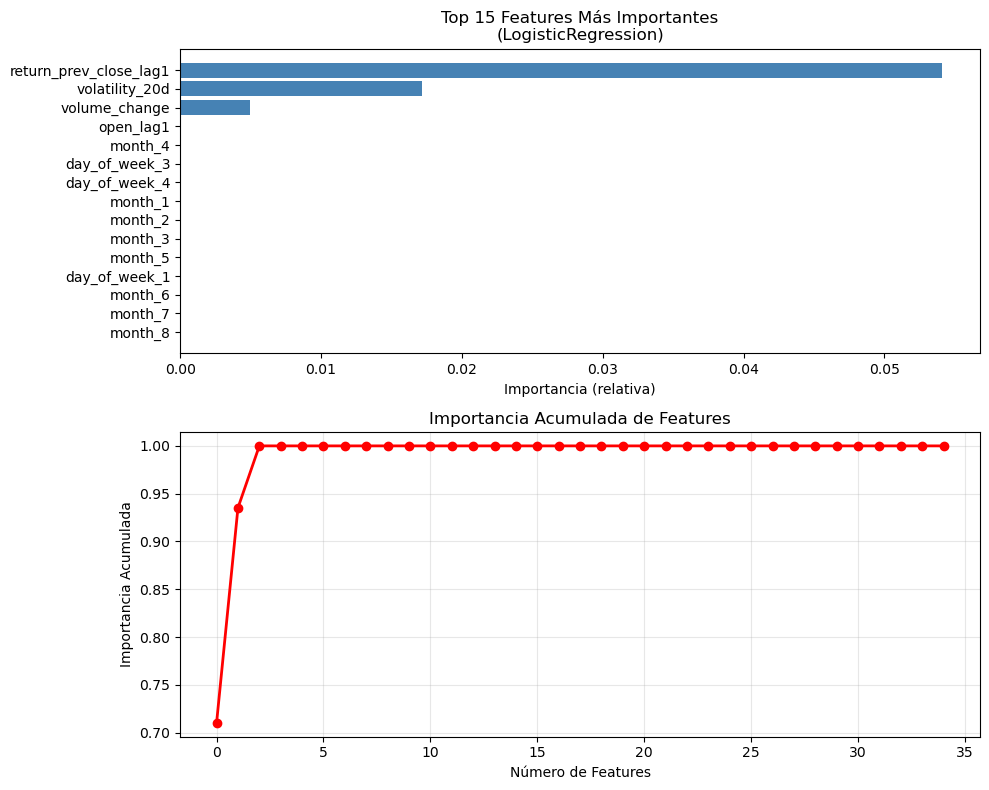


🏆 TOP 10 FEATURES MÁS IMPORTANTES:
    7. return_prev_close_lag1    0.0541
   17. volatility_20d            0.0171
   12. volume_change             0.0049
    1. open_lag1                 0.0000
   27. month_4                   0.0000
   22. day_of_week_3             0.0000
   23. day_of_week_4             0.0000
   24. month_1                   0.0000
   25. month_2                   0.0000
   26. month_3                   0.0000

💡 ANÁLISIS DE FEATURES:
   • La importancia se basa en: coeficientes absolutos (modelo lineal)
   • Features top 5 concentran ~100.0% de la importancia total
   • Features top 10 concentran ~100.0% de la importancia total


In [33]:
print("🔍 Analizando importancia de features...")

try:
    final_model = best_model.named_steps['model']
    preprocess = best_model.named_steps['preprocess']

    feature_names = []

    # 1) Nombres de features numéricas
    feature_names.extend(numeric_features)

    # 2) Nombres de features categóricas one-hot
    if 'cat' in preprocess.named_transformers_:
        cat_encoder = preprocess.named_transformers_['cat']
        if hasattr(cat_encoder, 'get_feature_names_out'):
            cat_features = cat_encoder.get_feature_names_out(categorical_features)
            feature_names.extend(cat_features)
        else:
            feature_names.extend(categorical_features)

    # === Caso 1: modelos de árbol con feature_importances_ ===
    if hasattr(final_model, 'feature_importances_'):
        importances = final_model.feature_importances_
        importance_type = "feature_importances_ (árboles)"
    # === Caso 2: modelos lineales con coef_ ===
    elif hasattr(final_model, 'coef_'):
        # Usamos la magnitud absoluta del coeficiente como importancia
        coefs = final_model.coef_
        if coefs.ndim > 1:  # multi–clase
            coefs = coefs[0]
        importances = np.abs(coefs)
        importance_type = "coeficientes absolutos (modelo lineal)"
    else:
        print(f"ℹ️  El modelo {best_model_name} no expone importancias directas.")
        print("   • Para este tipo de modelo haría falta SHAP, permutation importance, etc.")
        raise SystemExit

    if len(importances) != len(feature_names):
        print("⚠️  Discrepancia en número de features")
        print(f"   • Nombres: {len(feature_names)}, Importancias: {len(importances)}")
    else:
        importance_df = pd.DataFrame({
            "feature": feature_names,
            "importance": importances
        }).sort_values("importance", ascending=False)

        print(f"✅ Importancia de features calculada para {best_model_name} usando {importance_type}")

        # Gráficos
        plt.figure(figsize=(10, 8))

        plt.subplot(2, 1, 1)
        top_features = importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['importance'], color='steelblue')
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importancia (relativa)')
        plt.title(f'Top 15 Features Más Importantes\n({best_model_name})')
        plt.gca().invert_yaxis()

        plt.subplot(2, 1, 2)
        importance_df['cumulative_importance'] = importance_df['importance'] / importance_df['importance'].sum()
        importance_df['cumulative_importance'] = importance_df['cumulative_importance'].cumsum()
        plt.plot(range(len(importance_df)), importance_df['cumulative_importance'],
                 marker='o', linewidth=2, color='red')
        plt.xlabel('Número de Features')
        plt.ylabel('Importancia Acumulada')
        plt.title('Importancia Acumulada de Features')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        print("\n🏆 TOP 10 FEATURES MÁS IMPORTANTES:")
        for i, row in importance_df.head(10).iterrows():
            print(f"   {i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")

        print("\n💡 ANÁLISIS DE FEATURES:")
        print(f"   • La importancia se basa en: {importance_type}")
        print(f"   • Features top 5 concentran ~{importance_df.head(5)['importance'].sum() / importance_df['importance'].sum():.1%} de la importancia total")
        print(f"   • Features top 10 concentran ~{importance_df.head(10)['importance'].sum() / importance_df['importance'].sum():.1%} de la importancia total")

except SystemExit:
    pass
except Exception as e:
    print(f"❌ Error calculando importancia de features: {str(e)}")


In [34]:
print("🔍 Mostrando una fila real de X_test para inspección...")

sample = X_test.head(1)
display(sample)

print("\n🔮 Predicción del modelo sobre esta fila:")
sample_pred = best_model.predict(sample)
print("Predicción (target_up):", sample_pred[0])

# Si el modelo soporta probabilidades:
try:
    proba = best_model.predict_proba(sample)[:, 1]
    print("Probabilidad UP:", proba[0])
except:
    print("Este modelo no soporta predict_proba()")


🔍 Mostrando una fila real de X_test para inspección...


,open_lag1,high_lag1,low_lag1,close_lag1,volume_lag1,return_close_open_lag1,return_prev_close_lag1,volatility_5d_lag1,volume_ma_5,range_hl_lag1,price_range_pct,volume_change,ma_5_vs_20,momentum_5,momentum_10,volatility_10d,volatility_20d,rsi_14,day_of_week,month
1484,193.899994,194.399994,191.729996,192.529999,42672100.0,-0.007065,-0.005424,0.0035,38175720.0,0.013868,0.013868,1.253222,0.994203,-0.011044,-0.028166,0.004905,0.009078,40.185177,1,1



🔮 Predicción del modelo sobre esta fila:
Predicción (target_up): 1
Probabilidad UP: 0.5515981643805592


## Exportación del Modelo Entrenado para Uso en Producción

En este bloque se guarda el pipeline completo del modelo (preprocesamiento + modelo final) en un archivo .pkl, permitiendo su uso posterior dentro de la API. Además, se valida que el archivo funcione correctamente realizando una predicción de prueba y se genera un archivo JSON con las métricas, parámetros y configuración del experimento, asegurando trazabilidad y reproducibilidad del modelo en producción.

In [35]:
print("💾 Exportando modelo final...")

# Definir ruta para el modelo
MODEL_PATH = f"model_trading_{TICKER_MAIN}_{best_model_name}.pkl"

# Guardar modelo completo (pipeline con preprocesamiento)
joblib.dump(best_model, MODEL_PATH)

# Verificar que se guardó correctamente
if os.path.exists(MODEL_PATH):
    file_size = os.path.getsize(MODEL_PATH) / 1024 / 1024  # MB
    print(f"✅ Modelo guardado exitosamente:")
    print(f"   • Ruta: {MODEL_PATH}")
    print(f"   • Tamaño: {file_size:.2f} MB")
    print(f"   • Modelo: {best_model_name}")
    print(f"   • Ticker: {TICKER_MAIN}")
    print(f"   • Features: {len(feature_cols)}")
    
    # Cargar para verificar
    try:
        loaded_model = joblib.load(MODEL_PATH)
        # Probar predicción con un sample
        sample_pred = loaded_model.predict(X_test.head(1))
        print(f"   • Verificación: Predicción sample = {sample_pred[0]}")
        print(f"   • Estado: ✅ MODELO FUNCIONAL")
    except Exception as e:
        print(f"   • Error en verificación: {str(e)}")
else:
    print("❌ Error: No se pudo guardar el modelo")

# Guardar también información del experimento
experiment_info = {
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'ticker': TICKER_MAIN,
    'best_model': best_model_name,
    'best_params': best_row['best_params'],
    'test_metrics': {
        'accuracy': acc_test,
        'f1': f1_test,
        'precision': prec_test,
        'recall': rec_test,
        'roc_auc': roc_test
    },
    'financial_metrics': strategy_metrics,
    'features_used': feature_cols,
    'model_path': MODEL_PATH
}

# Guardar info del experimento
import json
info_path = f"experiment_info_{TICKER_MAIN}.json"
with open(info_path, 'w') as f:
    json.dump(experiment_info, f, indent=2)

print(f"📄 Información del experimento guardada en: {info_path}")

💾 Exportando modelo final...
✅ Modelo guardado exitosamente:
   • Ruta: model_trading_AAPL_LogisticRegression.pkl
   • Tamaño: 0.00 MB
   • Modelo: LogisticRegression
   • Ticker: AAPL
   • Features: 20
   • Verificación: Predicción sample = 1
   • Estado: ✅ MODELO FUNCIONAL
📄 Información del experimento guardada en: experiment_info_AAPL.json
